# Gesture Recognition project



# 1. EDA

Some simple EDA for basic information about the training data. While this is not required by the assignments, this will help in choosing the image processing technique, augmentations and so on.

In [1]:
import numpy as np
import os
import cv2
from cv2 import imread
import datetime
import os
from glob import glob
import matplotlib.pyplot as plt

# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

### Load data

In [2]:
# local
path = 'project_data/'

# set the seed for the same random permutation each time
np.random.seed(42)
train_doc = np.random.permutation(open(path+'train.csv').readlines())
val_doc = np.random.permutation(open(path+'val.csv').readlines())

Load the train doc and val doc to a dataframe

In [3]:
import pandas as pd

df = pd.DataFrame({'path': train_doc})
df['folder'] = df.path.apply(lambda x: x.split(';')[0])
df['label_name'] = df.path.apply(lambda x: x.split(';')[1])
df['label'] = df.path.apply(lambda x: x.split(';')[2][:1])
df['label'] = df['label'].astype(int)
df['file_count'] = df.folder.apply(lambda x: len(glob(path + 'train/' + x + '/*')))  
df['height'] = df.folder.apply(lambda folder_name: imread(glob(path + 'train/' + folder_name + '/*')[0]).shape[0])
df['width'] = df.folder.apply(lambda folder_name: imread(glob(path + 'train/' + folder_name + '/*')[0]).shape[1])
df.drop(columns='path').head()

,folder,label_name,label,file_count,height,width
0,WIN_20180925_18_23_57_Pro_Thumbs_Down_new,Thumbs_Down_new,3,30,120,160
1,WIN_20180907_16_21_11_Pro_Stop Gesture_new,Stop Gesture_new,2,30,360,360
2,WIN_20180907_16_38_29_Pro_Left Swipe_new_Left ...,Left Swipe_new_Left Swipe_new,0,30,360,360
3,WIN_20180926_17_23_38_Pro_Thumbs_Down_new,Thumbs_Down_new,3,30,120,160
4,WIN_20180926_17_21_49_Pro_Stop_new,Stop_new,2,30,120,160


In [4]:
df_val = pd.DataFrame({'path': val_doc})
df_val['folder'] = df_val.path.apply(lambda x: x.split(';')[0])
df_val['label_name'] = df_val.path.apply(lambda x: x.split(';')[1])
df_val['label'] = df_val.path.apply(lambda x: x.split(';')[2][:1])
df_val['label'] = df_val['label'].astype(int)
df_val['file_count'] = df_val.folder.apply(lambda x: len(glob(path + 'val/' + x + '/*')))  
df_val['height'] = df_val.folder.apply(lambda folder_name: imread(glob(path + 'val/' + folder_name + '/*')[0]).shape[0])
df_val['width'] = df_val.folder.apply(lambda folder_name: imread(glob(path + 'val/' + folder_name + '/*')[0]).shape[1])
df_val.drop(columns='path').head()

,folder,label_name,label,file_count,height,width
0,WIN_20180907_16_13_24_Pro_Thumbs Down_new,Thumbs Down_new,3,30,360,360
1,WIN_20180925_17_33_30_Pro_Thumbs_Down_new,Thumbs_Down_new,3,30,120,160
2,WIN_20180907_16_02_09_Pro_Thumbs Down_new,Thumbs Down_new,3,30,360,360
3,WIN_20180926_17_12_27_Pro_Right_Swipe_new,Right_Swipe_new,1,30,120,160
4,WIN_20180907_16_07_10_Pro_Thumbs Down_new,Thumbs Down_new,3,30,360,360


### Label counts

In [5]:
df.label_name.value_counts()

Right_Swipe_new                  103
Thumbs_Down_new                  100
Left_Swipe_new                    96
Stop_new                          93
Thumbs_Up_new                     87
Left Swipe_new_Left Swipe_new     40
Stop Gesture_new                  37
Thumbs Down_new                   37
Thumbs Up_new                     36
Right Swipe_new                   34
Name: label_name, dtype: int64

In [6]:
'Train label', df.label.value_counts(), 'Val label', df_val.label.value_counts()

('Train label',
 3    137
 1    137
 0    136
 2    130
 4    123
 Name: label, dtype: int64,
 'Val label',
 1    23
 2    22
 3    21
 0    18
 4    16
 Name: label, dtype: int64)

- Label name is a bit messy, but the label code is fine to use.

- Since the training data is fairly balanced, categorical accuracy is an appropriate metrics. No data imbalance handling is required.

### Number of images per sequence

In [7]:
df.file_count.value_counts()

30    663
Name: file_count, dtype: int64

All sample has exactly 30 images. For a camera at 30FPS, this equals exactly 1 second of footage.

In [9]:
def show_samples(label_class, sample_th=0):
    folder_name = df.folder[df.label==label_class].iloc[sample_th]
    print(f'Label: {df.label_name[df.folder==folder_name].iloc[0]}')
    image_list = glob(path + 'train/' + folder_name + '/*')

    fig = plt.figure(figsize=(15,4))
    for i, img in enumerate(image_list):
        ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[]) 
        plt.imshow(cv2.cvtColor(imread(img), cv2.COLOR_BGR2RGB))

In [ ]:
show_samples(label_class = 0, sample_th = 2)

In [ ]:
show_samples(1,4)

In [ ]:
show_samples(2,3)

In [ ]:
show_samples(3,2)

In [ ]:
show_samples(4)

### Choices for selecting image indices

#### All 30 images in a sequence
Use all images to train. This uses the most memory and takes longest time.

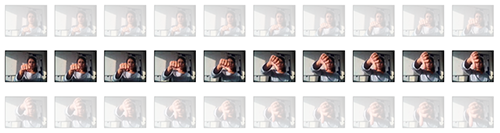

#### Every 2nd frame
Use every 2nd frames, total 15 frames. This cuts down memory / training time while still preserves the important details of the sequence.

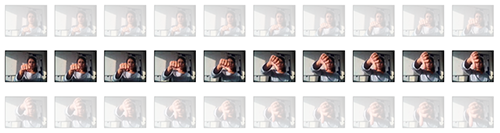

#### Every 3rd frame
Similar to above, but cuts down even further.

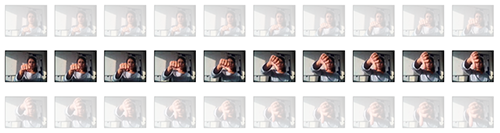

#### Middle 10 frames
Another alternative. The hypothesis here is that most of the motion happens in the middle frames. There are not much different in the first 10 or last 10 frames, as seen below.

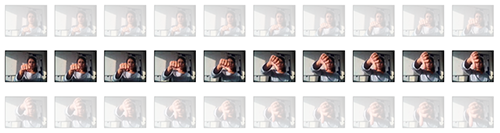

### Size/Dimension variation 

In [8]:
(df.height.astype(str)+' x '+df.width.astype(str)).value_counts()

120 x 160    479
360 x 360    184
dtype: int64

The majority are 120x160, but there are some 360x360.

### Image cropping/resizing strategy

#### Option 1. Downscaling without keeping proportion: 
**Pros:** No loss of information

**Cons:** the images are distorted and "squeezed", might create bias. See the outcome of 120x120 below

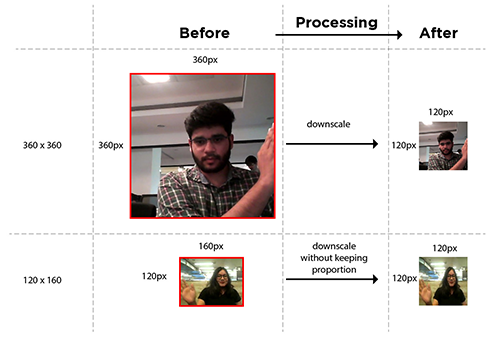

#### Option 2. Crop the 120x160 to 120x120 and downscale 360x360 to 120x120
**Pros:** no distortion in images.

**Cons:** loss of information for 120x160 (the sides of the images are deleted). This may result in inaccuracy where the information on the left/right sides are important (swipe left/right gestures).  See illustration below.

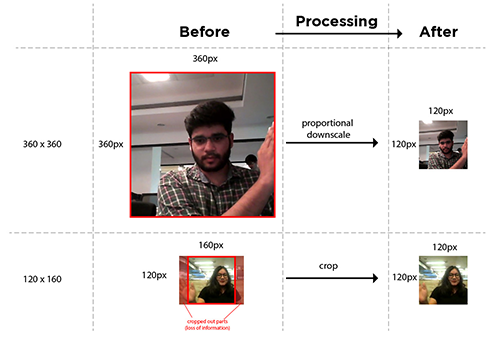

#### Option 3. Use 3:4 ratio
- 120x160 are preserved as-is. 
- 360x360 are cropped to 270x360 (3:4 ratio, same ratio as 120x160) then downscale to 120x160.

**Pros:** no distortion in images.

**Cons:** loss of information for 360x360. This might affect accuracy where information in the upper/lower parts of the images are important (thumb up/down gestures)

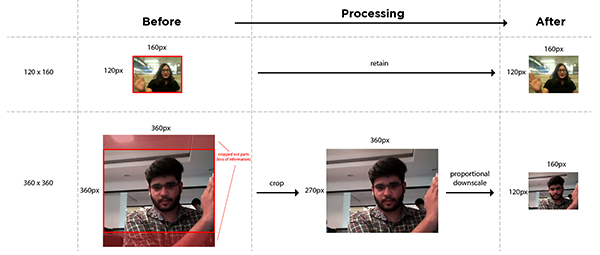

### Conclusion from EDA

- There are over 600 training datapoints and 100 cases for validation.
- Each sample has 30 frames, roughly 1 second of footage. Not all the frames may be required.
- The class distribution is fairly balanced, no handling required.
- There are variations in size and dimension. Different choices for cropping/resizing strategy will be tested.

# 2. Generator and function for training

### Load required libraries

In [15]:
import numpy as np
import os
import cv2
from cv2 import imread
# from scipy.misc import imresize
import datetime
import os
from glob import glob
import matplotlib.pyplot as plt
import time

# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Reshape, Dropout, ConvLSTM2D, GlobalAveragePooling2D, GlobalAveragePooling3D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Data path

In [16]:
# local
path = 'project_data/'

# set the seed for the same random permutation each time
np.random.seed(42)
train_doc = np.random.permutation(open(path+'train.csv').readlines())
val_doc = np.random.permutation(open(path+'val.csv').readlines())

train_path = path+'train/'
val_path = path+'val/'

model_save_path = 'model_save'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

###  Functions for image processing

In [17]:
# crop image to square size
def center_crop_to_square(img):
    # img expected to be a 3D array (height, width, channel)
    img_height, img_width = img.shape[0], img.shape[1]
    crop_size = int(min(img_height, img_width)/2)
    center_height, center_width = int(img_height/2), int(img_width/2)
    img = img[center_height-crop_size:center_height+crop_size , center_width-crop_size:center_width+crop_size, :]
    return img

In [18]:
# crop image to 4:3 ratio
def center_crop_ratio(img):
    ratio_height, ratio_width = 3, 4
    img_height, img_width = img.shape[0], img.shape[1]
    common_term = int(min(img_height/ratio_height, img_width/ratio_width))
    center_height, center_width = int(img_height/2), int(img_width/2)
    crop_height, crop_width = int(common_term*ratio_height/2), int(common_term*ratio_width/2)
    return img[center_height-crop_height:center_height+crop_height , center_width-crop_width:center_width+crop_width, :]

In [19]:
# resize
def ratio_resize(img, dimension):
    return cv2.resize(img, dimension)

# normalization
def minmax_norm(image_channel_array):
    return (image_channel_array - image_channel_array.min()) / (image_channel_array.max() - image_channel_array.min())

### Generator

The generator's arguments:
- source path: link to the image folder
- folder_list: link to the csv file
- full_batch_size: number of samples used in a full batch
- image_indices: list of images to be used in a sequence
- dimension: output's height, width
- use_ratio: False to keep image to square size. True to resize image proportionally to 3:4. Must match with specified dimension.
- augmentation_params: list of augmentation to apply. False to apply no augmentation in case of validation.

Note: in the starter code provided, the code for processing the last batch (the remaining after running full batches) were expected to be at the end of the generator. In my generator below, in the beginning there is a check whether the current iteration is the last batch, which if True will set the batch size to be the count of the remaining samples.

In [20]:
def generator(source_path, folder_list, full_batch_size, image_indices, dimension = (64,64), use_ratio=False, augmentation_params = False): 
    seq_length = len(image_indices)
    img_height = dimension[0]
    img_width = dimension[1]
    while True:
        np.random.seed(42)
        t = np.random.permutation(folder_list)
        if augmentation_params!=False:
            datagen = ImageDataGenerator(**augmentation_params)
        # calculate number of batches and the size of the last batch        
        if len(folder_list) % full_batch_size == 0: # can finish in full batch
            num_batches = len(folder_list) // full_batch_size
            last_batch_size = full_batch_size
        else: # need to specify the remaining batch size
            num_batches = len(folder_list) // full_batch_size + 1
            last_batch_size = len(folder_list) % full_batch_size
        
        # we iterate over the number of batches
        for batch_th in range(num_batches): 
            if batch_th+1 < num_batches: # not yet the last batch
                batch_size = full_batch_size
            else: # last batch reached
                batch_size = last_batch_size
            # create container
            # (number of samples per batch, number of photos in each sample, height, width, 3 channels)
            batch_data = np.zeros((batch_size,seq_length,img_height,img_width,3)) 
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5)) 
            # iterate over each image and replace the value in batch_data
            for folder_th in range(batch_size):
                # read all the images in the folder
                folder_name = t[(batch_th*full_batch_size) + folder_th].split(';')[0]
                # list of images in a folder. (full path because using glob)
                imgs = glob(source_path+folder_name+'/*')
                
                # get random transform for a sequence (declare the data gen here will apply the same transformation to all images in a sequence)
                if augmentation_params!=False:
                    # datagen = ImageDataGenerator(**augmentation_params)
                    random_transform = datagen.get_random_transform((img_height, img_width, 3))

                # image_indices is a list containing the index of the images we want to use.
                for idx,selected_index in enumerate(image_indices):
                    image = imread(imgs[selected_index])
                    # apply random augmentation
                    if augmentation_params!=False:
                        image = datagen.apply_transform(image, random_transform)
                    # resize/crop
                    if use_ratio==False:
                        image = center_crop_to_square(image)
                        image = ratio_resize(image, (img_width,img_height))
                    else: 
                        image = center_crop_ratio(image)
                        image = ratio_resize(image, (img_width,img_height))
                    
                    # add to the batch data
                    for img_channel in (0,1,2):
                        batch_data[folder_th,idx,:,:,img_channel] = minmax_norm(image[:,:,img_channel])
                    
                batch_labels[folder_th, int(t[(batch_th*full_batch_size) + folder_th].strip().split(';')[2])] = 1
            yield batch_data , batch_labels

### For training/validation

In [21]:
# calculate training steps/validation steps
def train_val_steps(train_doc, val_doc, batch_size):
    curr_dt_time = str(datetime.datetime.now()).replace(' ','_').replace(':','-').split('.')[0]
    print(f'current_date_time: {curr_dt_time}', end=' | ')
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences, end=' | ')
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print ('# epochs =', num_epochs, end=' | ')

    if (num_train_sequences%batch_size) == 0:
        training_steps = int(num_train_sequences/batch_size)
    else:
        training_steps = (num_train_sequences//batch_size) + 1
    print(f'train_steps_per_epoch {training_steps}', end=' | ')
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    print(f'val_validation_steps {validation_steps}')
    return curr_dt_time, training_steps, validation_steps

In [22]:
# create checkpoints
def create_checkpoint(model_name, curr_dt_time, monitor = 'val_categorical_accuracy'):
    name_path = f'{model_name}_{curr_dt_time}'
    if not os.path.exists(f'{model_save_path}/{name_path}'):
        os.mkdir(f'{model_save_path}/{name_path}')
    checkpoint = ModelCheckpoint(f'{model_save_path}/{name_path}/model_' + '{epoch:03d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5', 
                             monitor=monitor, verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
    return checkpoint

In [23]:
# plot loss/accuracy per epoch
def loss_accuracy_per_epoch(history, accuracy='categorical_accuracy'):
    fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=(8,3))
    ax1.plot(history.history['loss'], label= 'train')
    ax1.plot(history.history['val_loss'], label= 'val')
    ax1.set_title('Loss per epoch')
    ax2.plot(history.history[accuracy], label= 'train')
    ax2.plot(history.history['val_'+accuracy], label= 'val')
    ax2.set_title('Accuracy per epoch')
    ax2.legend(bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()

### Baseline models

Barebone, underfit models to test choices of parameters.

In [24]:
# basic model with 2 conv3d layers, 32 filter each
def conv3d_32_32(sequence_length, height, width):
    model = Sequential()

    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, height, width, 3)))
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dropout(0.25))

    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    return model

# basic model with 2 conv3d layers, 32 filters then 64 filters
def conv3d_32_64(sequence_length, height, width):
    model = Sequential()

    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, height, width, 3)))
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dropout(0.25))

    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    return model

# 3. Premilinary test for set choice of parameters

## 3.1 Testing batch size

### Fixed parameters

In [25]:
num_epochs = 8

image_indices = np.arange(10,20,1) # np.arange(2,30,3)
sequence_length = len(image_indices)

height, width, use_ratio = 64, 64, False # False for (1,1), True for (3,4)
# height, width, use_ratio = 72, 96, True

aug_params = False
callbacks_list = [] #LR, checkpoint, 

### Test batch size = 4, 8, 16, 32, 64, 128

In [30]:
# training parameter:
batch_sizes = [4, 8, 16, 32, 64, 128]
batch_size_test = []

for batch_size in batch_sizes:
    train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
    val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)
    curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)

    # create baseline models
    model = conv3d_32_32(sequence_length, height, width)
    
    # train
    start = time.time()
    history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                        validation_data=val_generator, validation_steps=validation_steps, 
                        callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)
    # save result
    batch_size_test += [(f'batch {batch_size}', history.history['val_categorical_accuracy'], time.time()-start)]

current_date_time: 2023-09-27_21-37-17 | # training sequences = 663 | # validation sequences = 100
# epochs = 8 | train_steps_per_epoch 166 | val_validation_steps 25
Epoch 1/8
166/166 [==============================] - 40s 238ms/step - loss: 1.7160 - categorical_accuracy: 0.2112 - val_loss: 1.4618 - val_categorical_accuracy: 0.3000
Epoch 2/8
166/166 [==============================] - 17s 103ms/step - loss: 1.2436 - categorical_accuracy: 0.4480 - val_loss: 1.1424 - val_categorical_accuracy: 0.5300
Epoch 3/8
166/166 [==============================] - 17s 103ms/step - loss: 0.7968 - categorical_accuracy: 0.7225 - val_loss: 2.6887 - val_categorical_accuracy: 0.4100
Epoch 4/8
166/166 [==============================] - 17s 103ms/step - loss: 0.3127 - categorical_accuracy: 0.9020 - val_loss: 1.2569 - val_categorical_accuracy: 0.5600
Epoch 5/8
166/166 [==============================] - 17s 104ms/step - loss: 0.2010 - categorical_accuracy: 0.9276 - val_loss: 1.3888 - val_categorical_accuracy: 0

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_14/max_pooling3d_14/MaxPool3D/MaxPool3DGrad' defined at (most recent call last):
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\nguye_5159g\AppData\Local\Temp\ipykernel_19508\3599021141.py", line 15, in <module>
      history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs,
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\nguye_5159g\anaconda3\envs\gpuscratch\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_14/max_pooling3d_14/MaxPool3D/MaxPool3DGrad'
OOM when allocating tensor with shape[128,32,13,62,62] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_14/max_pooling3d_14/MaxPool3D/MaxPool3DGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_42378]

Batch size of 64 is the limit. The notebook threw an error while running batch size of 128.

### Compare different batch sizes

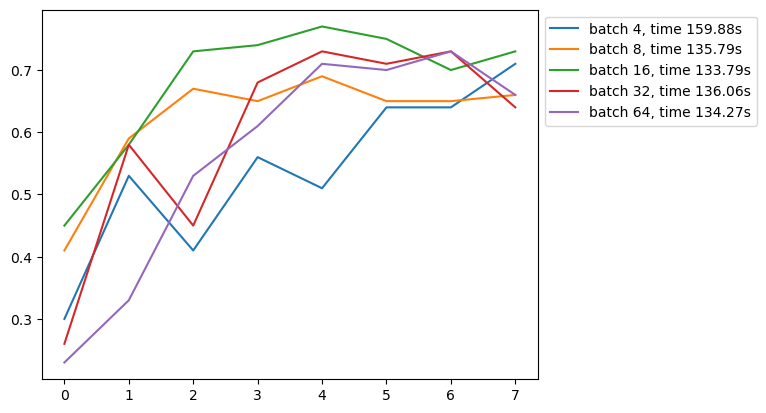

In [31]:
for batch_size, result, time_taken in batch_size_test:
    plt.plot(result, label=f'{batch_size}, time {time_taken:.2f}s')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Conclusion on batch size

- Batch size 16 generally gives the most consistent result. Choose batch size of 16 as default for later models and increase/decrease as needed.

## 3.2 Testing image indices

### Fixed parameters

In [32]:
num_epochs = 8
batch_size = 16

height, width, use_ratio = 64, 64, False # False for (1,1), True for (3,4)
# height, width, use_ratio = 72, 96, True
aug_params = False

### Test different image indices

In [33]:
# training parameter:
indices_list = [('10 middle frames', np.arange(10,20,1)),
                ('every 3rd frame', np.arange(2,30,3)),
                ('every 2nd frame', np.arange(1,30,2)),
                ('all frames', np.arange(0,30,1))
               ]
results = []



for indices_choice, image_indices in indices_list:
    sequence_length = len(image_indices)
    train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
    val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)
    curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)

    # create baseline models
    model = conv3d_32_32(sequence_length, height, width)
    
    # train
    start = time.time()
    history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                        validation_data=val_generator, validation_steps=validation_steps, 
                        callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)
    # save result
    results += [(f'{indices_choice}', history.history['val_categorical_accuracy'], time.time()-start)]

current_date_time: 2023-09-27_22-17-09 | # training sequences = 663 | # validation sequences = 100
# epochs = 8 | train_steps_per_epoch 42 | val_validation_steps 7
Epoch 1/8
42/42 [==============================] - 38s 908ms/step - loss: 1.7502 - categorical_accuracy: 0.1991 - val_loss: 1.5966 - val_categorical_accuracy: 0.1800
Epoch 2/8
42/42 [==============================] - 11s 271ms/step - loss: 1.5561 - categorical_accuracy: 0.2685 - val_loss: 1.5643 - val_categorical_accuracy: 0.2600
Epoch 3/8
42/42 [==============================] - 11s 271ms/step - loss: 1.3131 - categorical_accuracy: 0.4842 - val_loss: 1.3756 - val_categorical_accuracy: 0.4900
Epoch 4/8
42/42 [==============================] - 11s 270ms/step - loss: 0.9923 - categorical_accuracy: 0.6486 - val_loss: 1.2906 - val_categorical_accuracy: 0.5300
Epoch 5/8
42/42 [==============================] - 11s 271ms/step - loss: 0.7034 - categorical_accuracy: 0.7632 - val_loss: 1.2354 - val_categorical_accuracy: 0.5600
Epoch 

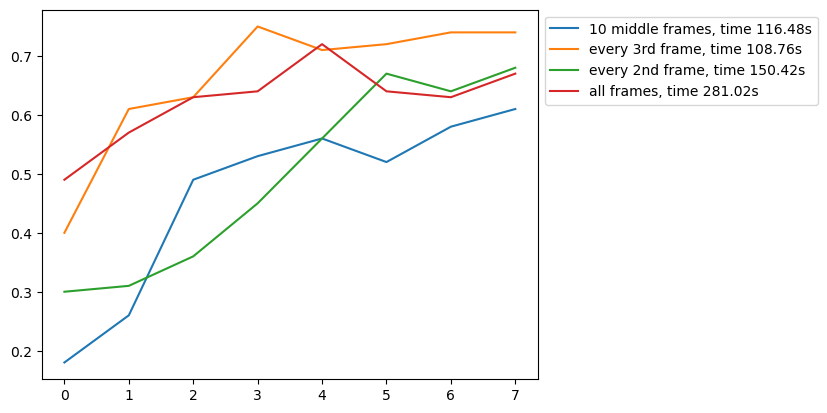

In [34]:
for choice, val_acc, time_taken in results:
    plt.plot(val_acc, label=f'{choice}, time {time_taken:.2f}s')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Conclusion on choice of image indices

- Use every 3rd frame gave the most balance performance/training time.
- Use more (every 2nd frame or all 30 frames), the performance declined while training time increased significantly. Reason for declined accuracy could be either due to noise in the model or the model was too simple to effectively capture the pattern available in the increased information given.
- Use only the 10 middle frames gave the worst result.

## 3.3 Test image dimension

### Fixed parameters

In [35]:
num_epochs = 10
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame

aug_params = False

### Test different dimensions

In [36]:
# training parameter:
dimensions_list = [
    ('square 64', (64, 64, False)),
    ('square 120', (120, 120, False)),
    ('4:3 ratio 72', (72, 96, True)),
    ('4:3 ratio 120', (120, 160, True))
]

results = []

for choice, dimension in dimensions_list:
    height, width, use_ratio = dimension
    sequence_length = len(image_indices)
    train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
    val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)
    curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)

    # create baseline models
    model = conv3d_32_32(sequence_length, height, width)
    
    # train
    start = time.time()
    history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                        validation_data=val_generator, validation_steps=validation_steps, 
                        callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)
    # save result
    results += [(f'{choice}', history.history['val_categorical_accuracy'], time.time()-start)]

current_date_time: 2023-09-27_22-28-06 | # training sequences = 663 | # validation sequences = 100
# epochs = 10 | train_steps_per_epoch 42 | val_validation_steps 7
Epoch 1/10
42/42 [==============================] - 12s 270ms/step - loss: 1.6786 - categorical_accuracy: 0.2519 - val_loss: 1.3665 - val_categorical_accuracy: 0.4200
Epoch 2/10
42/42 [==============================] - 11s 267ms/step - loss: 1.0234 - categorical_accuracy: 0.5928 - val_loss: 1.0491 - val_categorical_accuracy: 0.6300
Epoch 3/10
42/42 [==============================] - 11s 266ms/step - loss: 0.6008 - categorical_accuracy: 0.7919 - val_loss: 0.8573 - val_categorical_accuracy: 0.7200
Epoch 4/10
42/42 [==============================] - 11s 269ms/step - loss: 0.3790 - categorical_accuracy: 0.8763 - val_loss: 0.7653 - val_categorical_accuracy: 0.7500
Epoch 5/10
42/42 [==============================] - 11s 270ms/step - loss: 0.2347 - categorical_accuracy: 0.9291 - val_loss: 0.8984 - val_categorical_accuracy: 0.6700


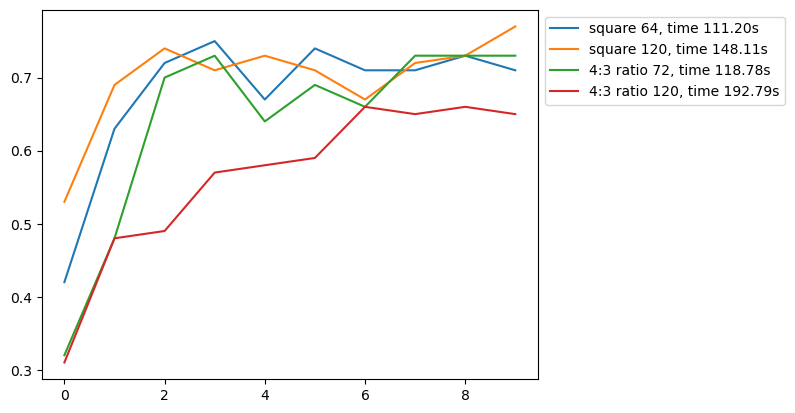

In [37]:
for choice, val_acc, time_taken in results:
    plt.plot(val_acc, label=f'{choice}, time {time_taken:.2f}s')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Conclusion on image dimension
- There's no clear winner. Can start with smaller resolution first.
- Square size perform a bit better. Higher resolution doesn't always mean better performance.

# 4. Conv3D models

### Model 1

In [38]:
# parameters
num_epochs = 10
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 64, 64, False # False for (1,1), True for (3,4)

optimizer_adam = 'adam'
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
callbacks_list = [] #LR, checkpoint, 

sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)

# model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, height, width, 3)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

# training sequences = 663
# validation sequences = 100
# epochs = 10
train_steps_per_epoch 42
val_validation_steps 7
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_64 (Conv3D)          (None, 10, 64, 64, 32)    2624      
                                                                 
 conv3d_65 (Conv3D)          (None, 8, 62, 62, 64)     55360     
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 4, 31, 31, 64)    0         
 g3D)                                                            
                                                                 
 dropout_64 (Dropout)        (None, 4, 31, 31, 64)     0         
                                                                 
 flatten_32 (Flatten)        (None, 246016)            0         
                                                                 
 

In [39]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
42/42 [==============================] - 12s 260ms/step - loss: 2.1088 - accuracy: 0.2745 - val_loss: 1.2620 - val_accuracy: 0.4900
Epoch 2/10
42/42 [==============================] - 10s 253ms/step - loss: 0.9679 - accuracy: 0.6214 - val_loss: 0.9220 - val_accuracy: 0.6500
Epoch 3/10
42/42 [==============================] - 10s 253ms/step - loss: 0.5342 - accuracy: 0.8265 - val_loss: 0.7335 - val_accuracy: 0.7000
Epoch 4/10
42/42 [==============================] - 10s 253ms/step - loss: 0.2789 - accuracy: 0.9125 - val_loss: 0.6588 - val_accuracy: 0.7300
Epoch 5/10
42/42 [==============================] - 11s 255ms/step - loss: 0.1535 - accuracy: 0.9532 - val_loss: 0.6511 - val_accuracy: 0.7400
Epoch 6/10
42/42 [==============================] - 10s 253ms/step - loss: 0.0948 - accuracy: 0.9713 - val_loss: 0.7795 - val_accuracy: 0.7700
Epoch 7/10
42/42 [==============================] - 10s 249ms/step - loss: 0.0522 - accuracy: 0.9894 - val_loss: 0.7549 - val_accuracy: 0.7800

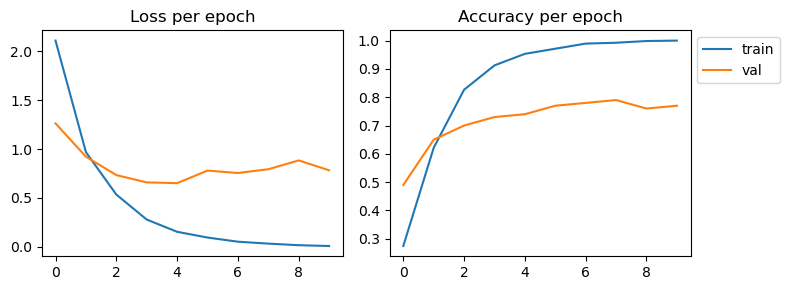

In [40]:
loss_accuracy_per_epoch(history)

Training loss/accuracy converged very fast while validation loss failed to go down. The learning rate might be too large for such simple model.

### Model 2
Reduced learning rate to 1e-4

In [53]:
# parameters
num_epochs = 10
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 64, 64, False # False for (1,1), True for (3,4)

optimizer_adam = optimizers.Adam(learning_rate=1e-4, epsilon=1e-3)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
callbacks_list = [LR] #checkpoint, 

sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)

# model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, height, width, 3)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

# training sequences = 663
# validation sequences = 100
# epochs = 10
train_steps_per_epoch 42
val_validation_steps 7
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_70 (Conv3D)          (None, 10, 64, 64, 32)    2624      
                                                                 
 conv3d_71 (Conv3D)          (None, 8, 62, 62, 64)     55360     
                                                                 
 max_pooling3d_35 (MaxPoolin  (None, 4, 31, 31, 64)    0         
 g3D)                                                            
                                                                 
 dropout_70 (Dropout)        (None, 4, 31, 31, 64)     0         
                                                                 
 flatten_35 (Flatten)        (None, 246016)            0         
                                                                 
 

In [54]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
42/42 [==============================] - 11s 261ms/step - loss: 1.6368 - accuracy: 0.2247 - val_loss: 1.5005 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/10
42/42 [==============================] - 11s 256ms/step - loss: 1.4326 - accuracy: 0.4329 - val_loss: 1.3298 - val_accuracy: 0.5900 - lr: 1.0000e-04
Epoch 3/10
42/42 [==============================] - 11s 260ms/step - loss: 1.2192 - accuracy: 0.5415 - val_loss: 1.1677 - val_accuracy: 0.6100 - lr: 1.0000e-04
Epoch 4/10
42/42 [==============================] - 11s 260ms/step - loss: 0.9629 - accuracy: 0.6606 - val_loss: 1.0240 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 5/10
42/42 [==============================] - 11s 258ms/step - loss: 0.7267 - accuracy: 0.7602 - val_loss: 0.8909 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 6/10
42/42 [==============================] - 11s 254ms/step - loss: 0.5406 - accuracy: 0.8477 - val_loss: 0.8009 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 7/10
42/42 [======================

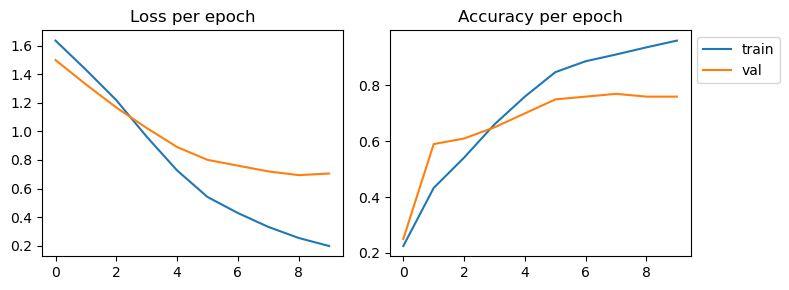

In [55]:
loss_accuracy_per_epoch(history)

Now the learning rate is smaller, the model still seems to be both overfitting and somewhat underfitting. 
- Training accuracy/loss still has not yet "flatten out" (underfitting). 
- Validation performance was a lot lower than training.

This can be improved with adding more layers/training for more epoch.

### Model 3
- Attempt to improve by adding a dense layer with 64 neurons for classification and running for more epochs

In [59]:
# parameters
num_epochs = 20
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 64, 64, False # False for (1,1), True for (3,4)

optimizer_adam = optimizers.Adam(learning_rate=1e-4, epsilon=1e-3)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
callbacks_list = [LR] #checkpoint, 

sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)

# model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, height, width, 3)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

# training sequences = 663
# validation sequences = 100
# epochs = 20
train_steps_per_epoch 42
val_validation_steps 7
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_74 (Conv3D)          (None, 10, 64, 64, 32)    2624      
                                                                 
 conv3d_75 (Conv3D)          (None, 8, 62, 62, 64)     55360     
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 4, 31, 31, 64)    0         
 g3D)                                                            
                                                                 
 dropout_74 (Dropout)        (None, 4, 31, 31, 64)     0         
                                                                 
 flatten_37 (Flatten)        (None, 246016)            0         
                                                                 
 

In [60]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
42/42 [==============================] - 11s 262ms/step - loss: 1.6188 - accuracy: 0.2187 - val_loss: 1.5749 - val_accuracy: 0.2700 - lr: 1.0000e-04
Epoch 2/20
42/42 [==============================] - 11s 255ms/step - loss: 1.5687 - accuracy: 0.2730 - val_loss: 1.5300 - val_accuracy: 0.3600 - lr: 1.0000e-04
Epoch 3/20
42/42 [==============================] - 11s 258ms/step - loss: 1.5187 - accuracy: 0.2896 - val_loss: 1.4618 - val_accuracy: 0.3900 - lr: 1.0000e-04
Epoch 4/20
42/42 [==============================] - 11s 258ms/step - loss: 1.4370 - accuracy: 0.3952 - val_loss: 1.3922 - val_accuracy: 0.4700 - lr: 1.0000e-04
Epoch 5/20
42/42 [==============================] - 11s 257ms/step - loss: 1.3362 - accuracy: 0.4404 - val_loss: 1.3100 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 6/20
42/42 [==============================] - 11s 255ms/step - loss: 1.2422 - accuracy: 0.4992 - val_loss: 1.1987 - val_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 7/20
42/42 [======================

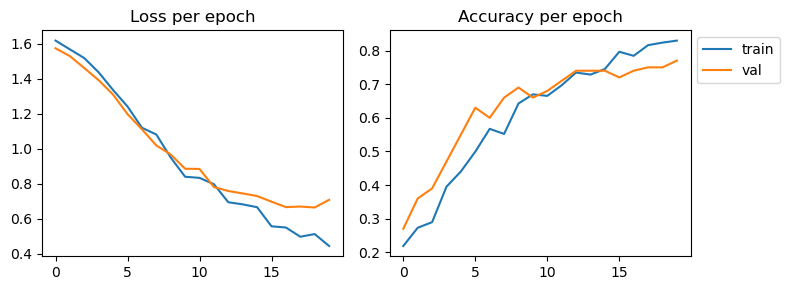

In [61]:
loss_accuracy_per_epoch(history)

- Adding more layer for classification seems to reduce overfitting. Validation loss/accuracy has improved alongside with training at each epoch.
- Underfitting issue remains. Loss and accuracy have not yet converged.

Train the same model for more epochs.

### Model 3.1

In [62]:
# parameters
num_epochs = 30
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 64, 64, False # False for (1,1), True for (3,4)

optimizer_adam = optimizers.Adam(learning_rate=1e-4, epsilon=1e-3)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
callbacks_list = [LR] #checkpoint, 

sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)

# model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, height, width, 3)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

# training sequences = 663
# validation sequences = 100
# epochs = 30
train_steps_per_epoch 42
val_validation_steps 7
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_76 (Conv3D)          (None, 10, 64, 64, 32)    2624      
                                                                 
 conv3d_77 (Conv3D)          (None, 8, 62, 62, 64)     55360     
                                                                 
 max_pooling3d_38 (MaxPoolin  (None, 4, 31, 31, 64)    0         
 g3D)                                                            
                                                                 
 dropout_76 (Dropout)        (None, 4, 31, 31, 64)     0         
                                                                 
 flatten_38 (Flatten)        (None, 246016)            0         
                                                                 
 

In [63]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
42/42 [==============================] - 11s 262ms/step - loss: 1.6520 - accuracy: 0.2051 - val_loss: 1.5723 - val_accuracy: 0.2400 - lr: 1.0000e-04
Epoch 2/30
42/42 [==============================] - 11s 255ms/step - loss: 1.5808 - accuracy: 0.2398 - val_loss: 1.5300 - val_accuracy: 0.2700 - lr: 1.0000e-04
Epoch 3/30
42/42 [==============================] - 11s 259ms/step - loss: 1.5521 - accuracy: 0.2519 - val_loss: 1.5044 - val_accuracy: 0.3700 - lr: 1.0000e-04
Epoch 4/30
42/42 [==============================] - 11s 257ms/step - loss: 1.5139 - accuracy: 0.3167 - val_loss: 1.4726 - val_accuracy: 0.3800 - lr: 1.0000e-04
Epoch 5/30
42/42 [==============================] - 11s 257ms/step - loss: 1.5062 - accuracy: 0.3228 - val_loss: 1.4664 - val_accuracy: 0.4400 - lr: 1.0000e-04
Epoch 6/30
42/42 [==============================] - 11s 255ms/step - loss: 1.4287 - accuracy: 0.3937 - val_loss: 1.4142 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/30
42/42 [======================

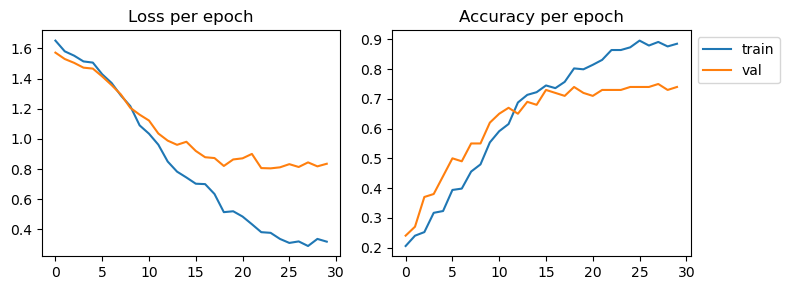

In [64]:
loss_accuracy_per_epoch(history)

Training for more epochs, training accuracy has been improved but not validation.

### Model 3.2
- Keep the same architecture but apply different cropping/resizing technique in the generator.

In [65]:
# parameters
num_epochs = 30
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 72, 96, True # False for (1,1), True for (3,4)
aug_params = False

optimizer_adam = optimizers.Adam(learning_rate=1e-4, epsilon=1e-3)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
callbacks_list = [LR] #checkpoint, 

sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)

# model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, height, width, 3)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

current_date_time: 2023-09-30_15-44-03 | # training sequences = 663 | # validation sequences = 100
# epochs = 30 | train_steps_per_epoch 42 | val_validation_steps 7
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 72, 96, 32)    2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 70, 94, 64)     55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 35, 47, 64)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 35, 47, 64)     0         
                                                                 
 flatten (Flatten)           (None, 421120)            0         
                       

In [ ]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

(the cell output here was cleared by accident)

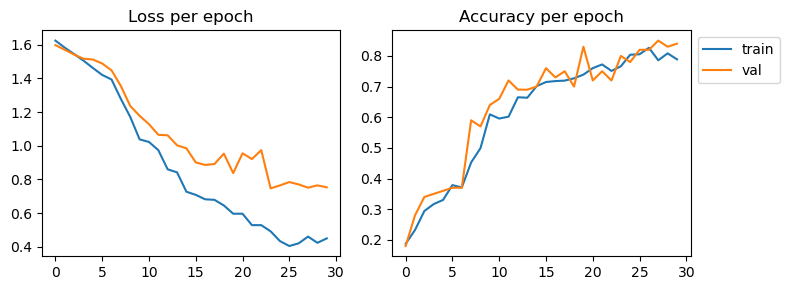

In [67]:
loss_accuracy_per_epoch(history)

Validation accuracy here are improving alongside with training accuracy. Looks like they have not converged yet.

### Model 3.3

In [71]:
# parameters
num_epochs = 50
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 72, 96, True # False for (1,1), True for (3,4)

optimizer_adam = optimizers.Adam(learning_rate=1e-4, epsilon=1e-3)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=num_epochs//10, min_lr=1e-5)
callbacks_list = [LR] #checkpoint, 

sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)

# model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, height, width, 3)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

# training sequences = 663
# validation sequences = 100
# epochs = 50
train_steps_per_epoch 42
val_validation_steps 7
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_82 (Conv3D)          (None, 10, 72, 96, 32)    2624      
                                                                 
 conv3d_83 (Conv3D)          (None, 8, 70, 94, 64)     55360     
                                                                 
 max_pooling3d_41 (MaxPoolin  (None, 4, 35, 47, 64)    0         
 g3D)                                                            
                                                                 
 dropout_82 (Dropout)        (None, 4, 35, 47, 64)     0         
                                                                 
 flatten_41 (Flatten)        (None, 421120)            0         
                                                                 
 

In [72]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
42/42 [==============================] - 12s 275ms/step - loss: 1.6246 - accuracy: 0.2353 - val_loss: 1.5662 - val_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 2/50
42/42 [==============================] - 11s 271ms/step - loss: 1.5048 - accuracy: 0.3363 - val_loss: 1.4692 - val_accuracy: 0.3600 - lr: 1.0000e-04
Epoch 3/50
42/42 [==============================] - 11s 271ms/step - loss: 1.3893 - accuracy: 0.4118 - val_loss: 1.3650 - val_accuracy: 0.5700 - lr: 1.0000e-04
Epoch 4/50
42/42 [==============================] - 11s 268ms/step - loss: 1.2411 - accuracy: 0.4585 - val_loss: 1.2578 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 5/50
42/42 [==============================] - 11s 274ms/step - loss: 1.1001 - accuracy: 0.5339 - val_loss: 1.1701 - val_accuracy: 0.5400 - lr: 1.0000e-04
Epoch 6/50
42/42 [==============================] - 11s 269ms/step - loss: 0.9818 - accuracy: 0.5897 - val_loss: 1.1761 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 7/50
42/42 [======================

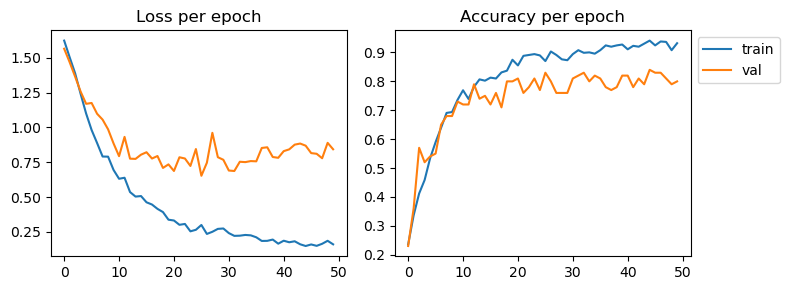

In [73]:
loss_accuracy_per_epoch(history)

- Training for more epochs no longer improves performance. 
- Add more layers for feature extraction.

### Model 4
- Add more conv3d layers for better feature extraction.

In [166]:
# parameters
model_name = 'model4_50e'
num_epochs = 50
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 72, 96, True # False for (1,1), True for (3,4)

# optimizer
optimizer_adam = optimizers.Adam(learning_rate=1e-4, epsilon=1e-3)
# Reduce LR
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=num_epochs//10, min_lr=1e-5)

# checkpoint
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)
checkpoint = create_checkpoint(model_name, curr_dt_time)
# Callback list
callbacks_list = [LR, checkpoint]
# generator
sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)

# model
model = Sequential()
model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, height, width, 3)))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

current_date_time: 2023-09-17_18-59-23 | # training sequences = 663 | # validation sequences = 100
# epochs = 50 | train_steps_per_epoch 42 | val_validation_steps 7
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_135 (Conv3D)         (None, 10, 72, 96, 16)    1312      
                                                                 
 conv3d_136 (Conv3D)         (None, 8, 70, 94, 32)     13856     
                                                                 
 max_pooling3d_75 (MaxPoolin  (None, 4, 35, 47, 32)    0         
 g3D)                                                            
                                                                 
 dropout_143 (Dropout)       (None, 4, 35, 47, 32)     0         
                                                                 
 conv3d_137 (Conv3D)         (None, 2, 33, 45, 64)     55360     
                    

In [167]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 1.6021 - categorical_accuracy: 0.2232
Epoch 1: val_categorical_accuracy improved from -inf to 0.28000, saving model to model_save/model4_50e_2023-09-17_18-59-23\model_001-1.60208-0.22323-1.58265-0.28000.h5
42/42 [==============================] - 12s 274ms/step - loss: 1.6021 - categorical_accuracy: 0.2232 - val_loss: 1.5826 - val_categorical_accuracy: 0.2800 - lr: 1.0000e-04
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 1.5855 - categorical_accuracy: 0.2459
Epoch 2: val_categorical_accuracy improved from 0.28000 to 0.30000, saving model to model_save/model4_50e_2023-09-17_18-59-23\model_002-1.58550-0.24585-1.56473-0.30000.h5
42/42 [==============================] - 11s 267ms/step - loss: 1.5855 - categorical_accuracy: 0.2459 - val_loss: 1.5647 - val_categorical_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 1.5558 - categorical_accuracy: 0.26

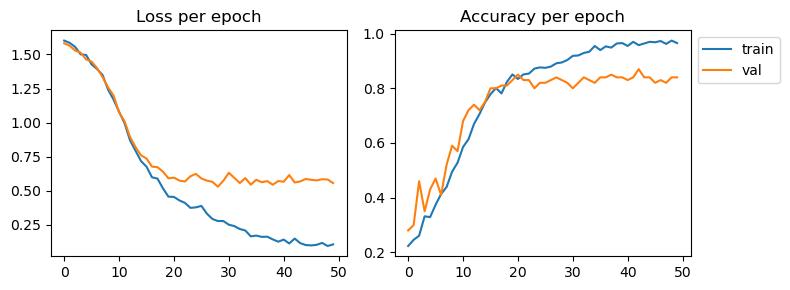

In [168]:
loss_accuracy_per_epoch(history, 'categorical_accuracy')

Validation loss and accuracy have improved. Overfitting remains an issue.

### Model 4.1 with random image augmentation
- Attempt to fix overfitting by applying random augmentation

In [25]:
# parameters
model_name = 'conv3D_model4_50e_aug'
num_epochs = 50
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 72, 96, True # False for (1,1), True for (3,4)
aug_params = {
    'rotation_range':10, 'brightness_range':[0.4,1.0], 'zoom_range':0.1,
    'zca_whitening':True, 'width_shift_range':0.1, 'height_shift_range':0.1}

# optimizer
optimizer_adam = optimizers.Adam(learning_rate=1e-4, epsilon=1e-3)
# Reduce LR
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=num_epochs//10, min_lr=1e-5)

# checkpoint
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)
checkpoint = create_checkpoint(model_name, curr_dt_time)
# Callback list
callbacks_list = [LR, checkpoint]
# generator
sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)

# model
model = Sequential()
model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, height, width, 3)))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

current_date_time: 2023-09-23_19-53-21 | # training sequences = 663 | # validation sequences = 100
# epochs = 50 | train_steps_per_epoch 42 | val_validation_steps 7
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 10, 72, 96, 16)    1312      
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 70, 94, 32)     13856     
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 4, 35, 47, 32)    0         
 3D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 4, 35, 47, 32)     0         
                                                                 
 conv3d_14 (Conv3D)          (None, 2, 33, 45, 64)     55360     
                     

In [26]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 1.6109 - categorical_accuracy: 0.1961
Epoch 1: val_categorical_accuracy improved from -inf to 0.23000, saving model to model_save/conv3D_model4_50e_aug_2023-09-23_19-53-21\model_001-1.61086-0.19608-1.59450-0.23000.h5
42/42 [==============================] - 66s 2s/step - loss: 1.6109 - categorical_accuracy: 0.1961 - val_loss: 1.5945 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 1.5901 - categorical_accuracy: 0.2217
Epoch 2: val_categorical_accuracy did not improve from 0.23000
42/42 [==============================] - 64s 2s/step - loss: 1.5901 - categorical_accuracy: 0.2217 - val_loss: 1.5820 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 1.5804 - categorical_accuracy: 0.2278
Epoch 3: val_categorical_accuracy improved from 0.23000 to 0.31000, saving model to model_save/conv3

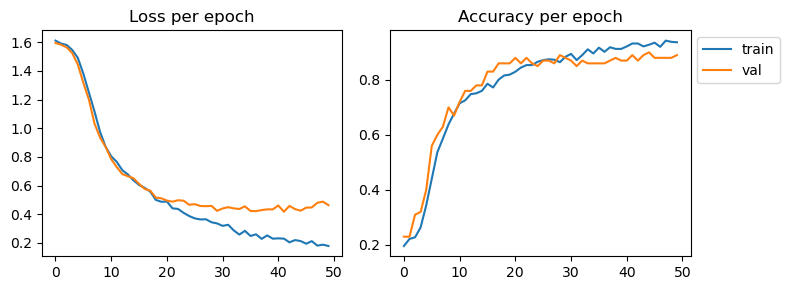

In [27]:
loss_accuracy_per_epoch(history, 'categorical_accuracy')

Both validation loss and accuracy have improved even further with random augmentation. Training accuracy doesn't seem to converge yet.

### Model 4.2 with random image augmentation

Train for more epoch

In [41]:
# parameters
model_name = 'conv3D_model4_100e_aug'
num_epochs = 100
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 72, 96, True # False for (1,1), True for (3,4)
aug_params = {
    'rotation_range':10, 'brightness_range':[0.4,1.0], 'zoom_range':0.1,
    'zca_whitening':True, 'width_shift_range':0.1, 'height_shift_range':0.1}

# optimizer
optimizer_adam = optimizers.Adam(learning_rate=1e-4, epsilon=1e-3)
# Reduce LR
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=num_epochs//10, min_lr=1e-5)

# checkpoint
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)
checkpoint = create_checkpoint(model_name, curr_dt_time)
# Callback list
callbacks_list = [LR, checkpoint]
# generator
sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)

# model
model = Sequential()
model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, height, width, 3)))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

current_date_time: 2023-09-24_01-15-18 | # training sequences = 663 | # validation sequences = 100
# epochs = 100 | train_steps_per_epoch 42 | val_validation_steps 7
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 10, 72, 96, 16)    1312      
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 70, 94, 32)     13856     
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 4, 35, 47, 32)    0         
 g3D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 4, 35, 47, 32)     0         
                                                                 
 conv3d_26 (Conv3D)          (None, 2, 33, 45, 64)     55360     
                   

In [42]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 1.6072 - categorical_accuracy: 0.2262
Epoch 1: val_categorical_accuracy improved from -inf to 0.27000, saving model to model_save/conv3D_model4_100e_aug_2023-09-24_01-15-18\model_001-1.60722-0.22624-1.57954-0.27000.h5
42/42 [==============================] - 69s 2s/step - loss: 1.6072 - categorical_accuracy: 0.2262 - val_loss: 1.5795 - val_categorical_accuracy: 0.2700 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 1.5843 - categorical_accuracy: 0.2489
Epoch 2: val_categorical_accuracy improved from 0.27000 to 0.28000, saving model to model_save/conv3D_model4_100e_aug_2023-09-24_01-15-18\model_002-1.58432-0.24887-1.56132-0.28000.h5
42/42 [==============================] - 63s 2s/step - loss: 1.5843 - categorical_accuracy: 0.2489 - val_loss: 1.5613 - val_categorical_accuracy: 0.2800 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 1.5622 - categ

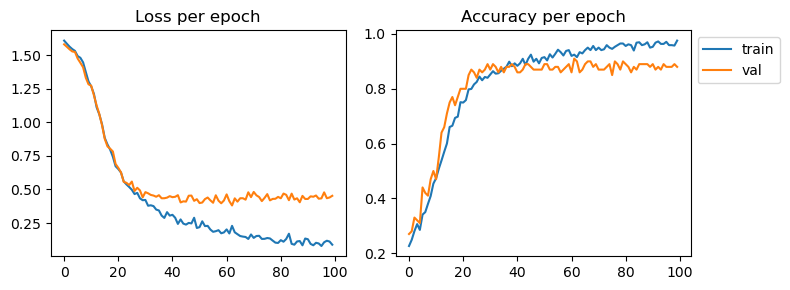

In [43]:
loss_accuracy_per_epoch(history, 'categorical_accuracy')

Training for more epoch doesn't seem to improve further.

### Model 4.3 (100 epoch) with random image augmentation, full size
Feed fullsize image

In [44]:
# parameters
model_name = 'conv3D_model4_50e_aug_fullsize'
num_epochs = 100
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 120, 160, True # False for (1,1), True for (3,4)
aug_params = {
    'rotation_range':10, 'brightness_range':[0.4,1.0], 'zoom_range':0.1,
    'zca_whitening':True, 'width_shift_range':0.1, 'height_shift_range':0.1}

# optimizer
optimizer_adam = optimizers.Adam(learning_rate=1e-4, epsilon=1e-3)
# Reduce LR
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=num_epochs//10, min_lr=1e-5)

# checkpoint
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)
checkpoint = create_checkpoint(model_name, curr_dt_time)
# Callback list
callbacks_list = [LR, checkpoint]
# generator
sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)

# model
model = Sequential()
model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, height, width, 3)))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

current_date_time: 2023-09-24_03-00-09 | # training sequences = 663 | # validation sequences = 100
# epochs = 100 | train_steps_per_epoch 42 | val_validation_steps 7
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 10, 120, 160, 16)  1312      
                                                                 
 conv3d_28 (Conv3D)          (None, 8, 118, 158, 32)   13856     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 4, 59, 79, 32)    0         
 g3D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 4, 59, 79, 32)     0         
                                                                 
 conv3d_29 (Conv3D)          (None, 2, 57, 77, 64)     55360     
                   

In [45]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 1.6291 - categorical_accuracy: 0.1991
Epoch 1: val_categorical_accuracy improved from -inf to 0.27000, saving model to model_save/conv3D_model4_50e_aug_fullsize_2023-09-24_03-00-09\model_001-1.62909-0.19910-1.60133-0.27000.h5
42/42 [==============================] - 66s 2s/step - loss: 1.6291 - categorical_accuracy: 0.1991 - val_loss: 1.6013 - val_categorical_accuracy: 0.2700 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 1.5957 - categorical_accuracy: 0.2127
Epoch 2: val_categorical_accuracy did not improve from 0.27000
42/42 [==============================] - 65s 2s/step - loss: 1.5957 - categorical_accuracy: 0.2127 - val_loss: 1.5810 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 1.5998 - categorical_accuracy: 0.2202
Epoch 3: val_categorical_accuracy did not improve from 0.27000
42/42 [==================

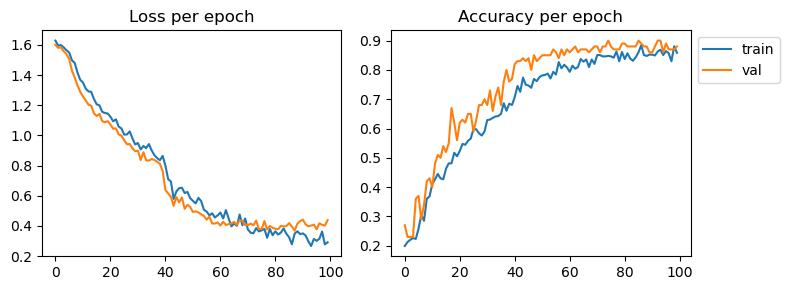

In [46]:
loss_accuracy_per_epoch(history)

Training on fullsize image doesn't improve validation accuracy by much, but seems to eliminate overfitting issue. Both loss and accuracy improved in a very similar manner at each epoch. Also this model and generator parameter manage to achieve the lowest validation loss so far.

### Conclusion for Conv3D models

- So far, Conv3d model manage to achieve 0.91 validation accuracy.
- Using random image augmentation helped with improving loss/accuracy and overfitting issue, but takes more epochs, and more time per epoch, to train.
- While the model can get a good validation accuracy by training on image size as small as 72x96, using larger image 120x160 helped further with overfitting.

# 5. CNN + RNN

### Model 1
Start with a basic model

In [81]:
# parameters
num_epochs = 50
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 72, 96, True # False for (1,1), True for (3,4)
aug_params = False

optimizer_adam = optimizers.Adam(learning_rate=1e-2, epsilon=1e-3)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=num_epochs//10, min_lr=1e-5)
callbacks_list = [LR] #checkpoint, 

sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 50
train_steps_per_epoch 42
val_validation_steps 7


In [85]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=(sequence_length, height, width, 3))
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_11 (TimeDi  (None, 10, 70, 94, 8)    224       
 stributed)                                                      
                                                                 
 batch_normalization_14 (Bat  (None, 10, 70, 94, 8)    32        
 chNormalization)                                                
                                                                 
 time_distributed_12 (TimeDi  (None, 10, 68, 92, 16)   1168      
 stributed)                                                      
                                                                 
 batch_normalization_15 (Bat  (None, 10, 68, 92, 16)   64        
 chNormalization)                                                
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 66, 90, 8)       

In [86]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
42/42 [==============================] - 15s 303ms/step - loss: 1.3860 - accuracy: 0.3937 - val_loss: 1.7611 - val_accuracy: 0.1800 - lr: 0.0100
Epoch 2/50
42/42 [==============================] - 12s 284ms/step - loss: 1.0837 - accuracy: 0.5264 - val_loss: 1.8226 - val_accuracy: 0.1800 - lr: 0.0100
Epoch 3/50
42/42 [==============================] - 12s 283ms/step - loss: 0.8935 - accuracy: 0.6063 - val_loss: 2.2630 - val_accuracy: 0.3500 - lr: 0.0100
Epoch 4/50
42/42 [==============================] - 12s 281ms/step - loss: 0.8522 - accuracy: 0.6440 - val_loss: 1.3010 - val_accuracy: 0.3800 - lr: 0.0100
Epoch 5/50
42/42 [==============================] - 12s 287ms/step - loss: 0.7314 - accuracy: 0.7014 - val_loss: 1.4305 - val_accuracy: 0.3400 - lr: 0.0100
Epoch 6/50
42/42 [==============================] - 12s 290ms/step - loss: 0.7198 - accuracy: 0.6938 - val_loss: 1.2313 - val_accuracy: 0.4300 - lr: 0.0100
Epoch 7/50
42/42 [==============================] - 12s 281ms/st

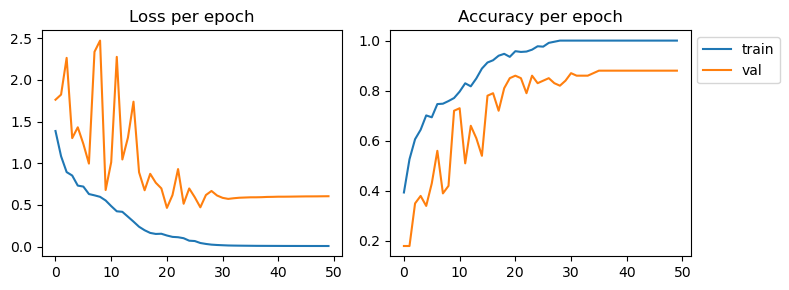

In [87]:
loss_accuracy_per_epoch(history)

Observe clear sign of overfitting. Validation loss/accuracy plateaued out.

### Model 2
Reduce learning rate to 1e-3

In [18]:
# parameters
model_name = 'model2_conv2dlstm'
num_epochs = 50
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 72, 96, True # False for (1,1), True for (3,4)
aug_params = False

# optimizer
optimizer_adam = optimizers.Adam(learning_rate=1e-3, epsilon=1e-4)
# Reduce LR
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=num_epochs//10, min_lr=1e-5)

# checkpoint
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)
checkpoint = create_checkpoint(model_name, curr_dt_time)
# Callback list
callbacks_list = [LR, checkpoint]
# generator
sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)

current_date_time: 2023-09-23_15-09-56 | # training sequences = 663 | # validation sequences = 100
# epochs = 50 | train_steps_per_epoch 42 | val_validation_steps 7


In [19]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=(sequence_length, height, width, 3))
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 10, 70, 94, 8)    224       
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 10, 70, 94, 8)    32        
 hNormalization)                                                 
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 68, 92, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 10, 68, 92, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 66, 90, 8)        

In [20]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 1.4376 - categorical_accuracy: 0.3846
Epoch 1: val_categorical_accuracy improved from -inf to 0.22000, saving model to model_save/model2_conv2dlstm_2023-09-23_15-09-56\model_001-1.43762-0.38462-1.59404-0.22000.h5
42/42 [==============================] - 15s 298ms/step - loss: 1.4376 - categorical_accuracy: 0.3846 - val_loss: 1.5940 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 1.2192 - categorical_accuracy: 0.4842
Epoch 2: val_categorical_accuracy improved from 0.22000 to 0.23000, saving model to model_save/model2_conv2dlstm_2023-09-23_15-09-56\model_002-1.21923-0.48416-1.58109-0.23000.h5
42/42 [==============================] - 12s 284ms/step - loss: 1.2192 - categorical_accuracy: 0.4842 - val_loss: 1.5811 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 1.0791 - categorical_accuracy

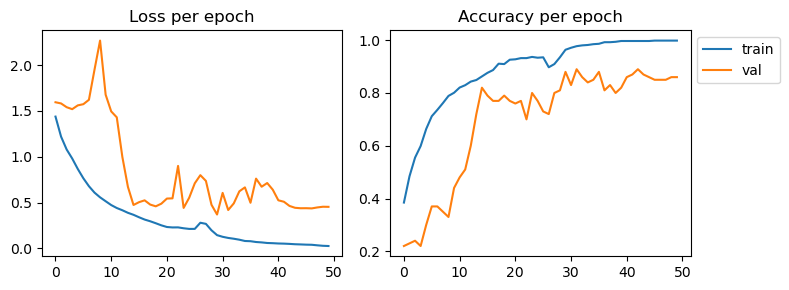

In [24]:
loss_accuracy_per_epoch(history)

Overfitting still remains

### Model 3 with image augmentation
Apply augmentation to help with overfitting. Also increase number of epochs due to random augmentation

In [47]:
# parameters
model_name = 'model3_conv2dlstm_aug'
num_epochs = 100
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 72, 96, True # False for (1,1), True for (3,4)
aug_params = {
    'rotation_range':10, 'brightness_range':[0.4,1.0], 'zoom_range':0.1,
    'zca_whitening':True, 'width_shift_range':0.1, 'height_shift_range':0.1}

# optimizer
optimizer_adam = optimizers.Adam(learning_rate=1e-4, epsilon=1e-4)
# Reduce LR
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=num_epochs//10, min_lr=1e-5)

# checkpoint
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)
checkpoint = create_checkpoint(model_name, curr_dt_time)
# Callback list
callbacks_list = [LR, checkpoint]
# generator
sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)

current_date_time: 2023-09-24_04-48-14 | # training sequences = 663 | # validation sequences = 100
# epochs = 100 | train_steps_per_epoch 42 | val_validation_steps 7


In [48]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'), input_shape=(sequence_length, height, width, 3))
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(16, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 10, 70, 94, 16)   448       
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 10, 70, 94, 16)   64        
 hNormalization)                                                 
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 68, 92, 32)   4640      
 tributed)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 10, 68, 92, 32)   128       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 66, 90, 16)      

In [49]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 1.6000 - categorical_accuracy: 0.2187
Epoch 1: val_categorical_accuracy improved from -inf to 0.25000, saving model to model_save/model3_conv2dlstm_aug_2023-09-24_04-48-14\model_001-1.59998-0.21870-1.60633-0.25000.h5
42/42 [==============================] - 66s 2s/step - loss: 1.6000 - categorical_accuracy: 0.2187 - val_loss: 1.6063 - val_categorical_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 1.5211 - categorical_accuracy: 0.3333
Epoch 2: val_categorical_accuracy did not improve from 0.25000
42/42 [==============================] - 63s 2s/step - loss: 1.5211 - categorical_accuracy: 0.3333 - val_loss: 1.6052 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 1.4600 - categorical_accuracy: 0.3982
Epoch 3: val_categorical_accuracy did not improve from 0.25000
42/42 [===========================

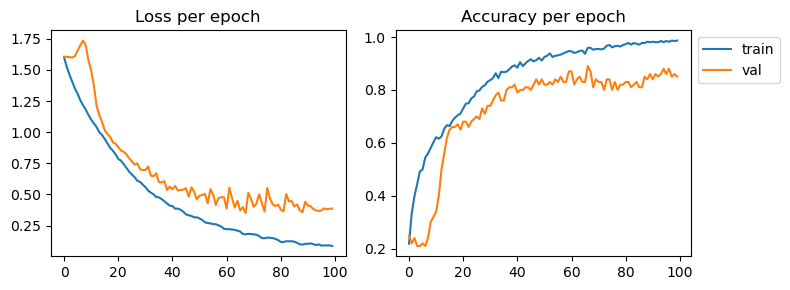

In [50]:
loss_accuracy_per_epoch(history)

Applying random augmentation does not help much. Suspect that the model is too simple, hence unable to learn enough features to generalize to the validation set.

### Model 4 no augmentation
- Increase the number of filters in the CNN layers and neurons in classification layers.

In [26]:
# parameters
model_name = 'model4_conv2dlstm'
num_epochs = 25
batch_size = 8
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 72, 96, True # False for (1,1), True for (3,4)
aug_params = False
# aug_params = {
#     'rotation_range':10, 'brightness_range':[0.4,1.0], 'zoom_range':0.1,
#     'zca_whitening':True, 'width_shift_range':0.1, 'height_shift_range':0.1}

# optimizer
optimizer_adam = optimizers.Adam(learning_rate=1e-3, epsilon=1e-4)
# Reduce LR
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=num_epochs//10, min_lr=1e-5)

# checkpoint
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)
checkpoint = create_checkpoint(model_name, curr_dt_time)
# Callback list
callbacks_list = [LR, checkpoint]
# generator
sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)

current_date_time: 2023-09-24_18-42-43 | # training sequences = 663 | # validation sequences = 100
# epochs = 25 | train_steps_per_epoch 83 | val_validation_steps 13


In [27]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=(sequence_length, height, width, 3))
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(32, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(128, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 10, 70, 94, 32)   896       
 stributed)                                                      
                                                                 
 batch_normalization_20 (Bat  (None, 10, 70, 94, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_16 (TimeDi  (None, 10, 68, 92, 64)   18496     
 stributed)                                                      
                                                                 
 batch_normalization_21 (Bat  (None, 10, 68, 92, 64)   256       
 chNormalization)                                                
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 66, 90, 32)       

In [28]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.3353 - categorical_accuracy: 0.4344
Epoch 1: val_categorical_accuracy improved from -inf to 0.26000, saving model to model_save/model4_conv2dlstm_2023-09-24_18-42-43\model_001-1.33528-0.43439-1.58503-0.26000.h5
83/83 [==============================] - 26s 284ms/step - loss: 1.3353 - categorical_accuracy: 0.4344 - val_loss: 1.5850 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.0262 - categorical_accuracy: 0.5852
Epoch 2: val_categorical_accuracy did not improve from 0.26000
83/83 [==============================] - 23s 280ms/step - loss: 1.0262 - categorical_accuracy: 0.5852 - val_loss: 1.6290 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 0.8694 - categorical_accuracy: 0.6652
Epoch 3: val_categorical_accuracy did not improve from 0.26000
83/83 [==============================] - 23

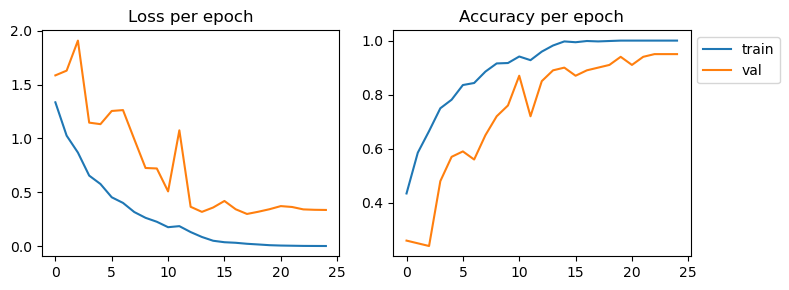

In [29]:
loss_accuracy_per_epoch(history)

Increase model complexity helped with validation accuracy (95%)

### Model 4.1 with augmentation

Enable image augmentation

In [37]:
# parameters
model_name = 'model4_conv2dlstm_aug'
num_epochs = 50
batch_size = 8
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 72, 96, True # False for (1,1), True for (3,4)
aug_params = {
    'rotation_range':10, 'brightness_range':[0.4,1.0], 'zoom_range':0.1,
    'zca_whitening':True, 'width_shift_range':0.1, 'height_shift_range':0.1}

# optimizer
optimizer_adam = optimizers.Adam(learning_rate=1e-4, epsilon=1e-4)
# Reduce LR
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=num_epochs//10, min_lr=1e-5)

# checkpoint
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)
checkpoint = create_checkpoint(model_name, curr_dt_time)
# Callback list
callbacks_list = [LR, checkpoint]
# generator
sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)

current_date_time: 2023-09-24_19-36-08 | # training sequences = 663 | # validation sequences = 100
# epochs = 50 | train_steps_per_epoch 83 | val_validation_steps 13


In [38]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=(sequence_length, height, width, 3))
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(32, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(128, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 10, 70, 94, 32)   896       
 stributed)                                                      
                                                                 
 batch_normalization_28 (Bat  (None, 10, 70, 94, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_22 (TimeDi  (None, 10, 68, 92, 64)   18496     
 stributed)                                                      
                                                                 
 batch_normalization_29 (Bat  (None, 10, 68, 92, 64)   256       
 chNormalization)                                                
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 66, 90, 32)       

In [39]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
83/83 [==============================] - ETA: 0s - loss: 1.5023 - categorical_accuracy: 0.3544
Epoch 1: val_categorical_accuracy improved from -inf to 0.31000, saving model to model_save/model4_conv2dlstm_aug_2023-09-24_19-36-08\model_001-1.50228-0.35445-1.61522-0.31000.h5
83/83 [==============================] - 69s 807ms/step - loss: 1.5023 - categorical_accuracy: 0.3544 - val_loss: 1.6152 - val_categorical_accuracy: 0.3100 - lr: 1.0000e-04
Epoch 2/50
83/83 [==============================] - ETA: 0s - loss: 1.3473 - categorical_accuracy: 0.4676
Epoch 2: val_categorical_accuracy did not improve from 0.31000
83/83 [==============================] - 67s 811ms/step - loss: 1.3473 - categorical_accuracy: 0.4676 - val_loss: 1.5803 - val_categorical_accuracy: 0.2800 - lr: 1.0000e-04
Epoch 3/50
83/83 [==============================] - ETA: 0s - loss: 1.2164 - categorical_accuracy: 0.5445
Epoch 3: val_categorical_accuracy did not improve from 0.31000
83/83 [========================

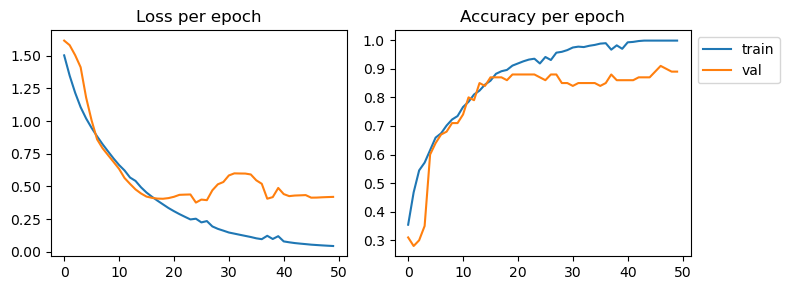

In [40]:
loss_accuracy_per_epoch(history)

Enable image augmentation does not seem to help with improving loss/accuracy.

### Conclusion for CNN + RNN models

- CNN+RNN models were able to achieve a better performance in validation accuracy (95%) than Conv3D models (91%), despite having less parameters.
- Enable random image augmentation doesn't seem to help much.

# 6. Transfer learning

For the requirement of this assignment, Mobilenet seems to be an appropriate choice. MobileNet is a lightweight model developed by Google Research team. It was designed to effectively maximize accuracy while still being small, low-latency, low-power, parameterized to work under the resource constraints (especially on-device or embedded application).

In [41]:
from keras.applications import mobilenet

### Model 1. Train only classification layers and finetune later

In [57]:
# parameters
model_name = 'mobilenet1'
num_epochs = 30
batch_size = 8
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 128, 128, False # False for (1,1), True for (3,4)

aug_params = False
# aug_params = {
#     'rotation_range':10, 'brightness_range':[0.4,1.0], 'zoom_range':0.1,
#     'zca_whitening':True, 'width_shift_range':0.1, 'height_shift_range':0.1}

# optimizer
optimizer_adam = optimizers.Adam(learning_rate=1e-3, epsilon=1e-4)
# Reduce LR
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=num_epochs//10, min_lr=1e-5)

# checkpoint
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)
checkpoint = create_checkpoint(model_name, curr_dt_time)
# Callback list
callbacks_list = [LR, checkpoint]
# generator
sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)

current_date_time: 2023-09-24_20-42-15 | # training sequences = 663 | # validation sequences = 100
# epochs = 30 | train_steps_per_epoch 83 | val_validation_steps 13


In [58]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(height, width, 3))
mobilenet_transfer.trainable = False

In [59]:
model = Sequential()
model.add(TimeDistributed(
    mobilenet_transfer, input_shape=(sequence_length, height, width, 3))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(32, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(128, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 10, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 batch_normalization_41 (Bat  (None, 10, 4, 4, 1024)   4096      
 chNormalization)                                                
                                                                 
 conv_lstm2d_11 (ConvLSTM2D)  (None, 2, 2, 32)         1216640   
                                                                 
 batch_normalization_42 (Bat  (None, 2, 2, 32)         128       
 chNormalization)                                                
                                                                 
 time_distributed_31 (TimeDi  (None, 2, 2, 128)        4224      
 stributed)                                          

In [60]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.9623 - categorical_accuracy: 0.6425
Epoch 1: val_categorical_accuracy improved from -inf to 0.82000, saving model to model_save/mobilenet1_2023-09-24_20-42-15\model_001-0.96228-0.64253-0.87657-0.82000.h5
83/83 [==============================] - 19s 185ms/step - loss: 0.9623 - categorical_accuracy: 0.6425 - val_loss: 0.8766 - val_categorical_accuracy: 0.8200 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.3443 - categorical_accuracy: 0.9035
Epoch 2: val_categorical_accuracy did not improve from 0.82000
83/83 [==============================] - 14s 172ms/step - loss: 0.3443 - categorical_accuracy: 0.9035 - val_loss: 0.5034 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.1319 - categorical_accuracy: 0.9623
Epoch 3: val_categorical_accuracy improved from 0.82000 to 0.84000, saving model to model_save/mobilenet1_2023-09

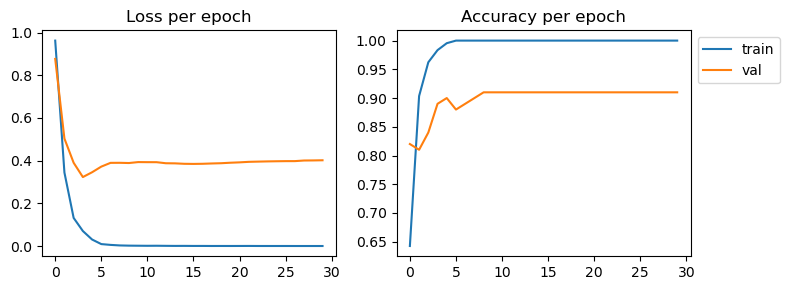

In [61]:
loss_accuracy_per_epoch(history)

In [62]:
#unfreeze and finetune for 10 epochs with low epoch
mobilenet_transfer.trainable = True

num_epochs = 10
# optimizer
optimizer_adam = optimizers.Adam(learning_rate=1e-5, epsilon=1e-4)
# checkpoint
_ , training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)


model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

current_date_time: 2023-09-24_20-51-24 | # training sequences = 663 | # validation sequences = 100
# epochs = 10 | train_steps_per_epoch 83 | val_validation_steps 13
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 10, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 batch_normalization_41 (Bat  (None, 10, 4, 4, 1024)   4096      
 chNormalization)                                                
                                                                 
 conv_lstm2d_11 (ConvLSTM2D)  (None, 2, 2, 32)         1216640   
                                                                 
 batch_normalization_42 (Bat  (None, 2, 2, 32)         128       
 chNormalization)                                                
                   

In [63]:
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
83/83 [==============================] - ETA: 0s - loss: 0.1816 - categorical_accuracy: 0.9367
Epoch 1: val_categorical_accuracy did not improve from 0.91000
83/83 [==============================] - 27s 272ms/step - loss: 0.1816 - categorical_accuracy: 0.9367 - val_loss: 0.6755 - val_categorical_accuracy: 0.8500 - lr: 1.0000e-05
Epoch 2/10
83/83 [==============================] - ETA: 0s - loss: 0.0270 - categorical_accuracy: 0.9955
Epoch 2: val_categorical_accuracy did not improve from 0.91000
83/83 [==============================] - 22s 259ms/step - loss: 0.0270 - categorical_accuracy: 0.9955 - val_loss: 0.7204 - val_categorical_accuracy: 0.8200 - lr: 1.0000e-05
Epoch 3/10
83/83 [==============================] - ETA: 0s - loss: 0.0100 - categorical_accuracy: 1.0000
Epoch 3: val_categorical_accuracy did not improve from 0.91000
83/83 [==============================] - 22s 261ms/step - loss: 0.0100 - categorical_accuracy: 1.0000 - val_loss: 0.7565 - val_categorical_accuracy

### Model 1.1 Retrain all layers

In [94]:
# parameters
model_name = 'mobilenet1_retrain'
num_epochs = 30
batch_size = 8
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 128, 128, False # False for (1,1), True for (3,4)

aug_params = False
# aug_params = {
#     'rotation_range':10, 'brightness_range':[0.4,1.0], 'zoom_range':0.1,
#     'zca_whitening':True, 'width_shift_range':0.1, 'height_shift_range':0.1}

# optimizer
optimizer_adam = optimizers.Adam(learning_rate=1e-3, epsilon=1e-4)
# Reduce LR
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=num_epochs//10, min_lr=1e-5)

# checkpoint
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)
checkpoint = create_checkpoint(model_name, curr_dt_time)
# Callback list
callbacks_list = [LR, checkpoint]
# generator
sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)

current_date_time: 2023-09-24_22-58-40 | # training sequences = 663 | # validation sequences = 100
# epochs = 30 | train_steps_per_epoch 83 | val_validation_steps 13


In [95]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(height, width, 3))
mobilenet_transfer.trainable = True

In [96]:
model = Sequential()
model.add(TimeDistributed(
    mobilenet_transfer, input_shape=(sequence_length, height, width, 3))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(32, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(128, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_44 (TimeDi  (None, 10, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 batch_normalization_62 (Bat  (None, 10, 4, 4, 1024)   4096      
 chNormalization)                                                
                                                                 
 conv_lstm2d_18 (ConvLSTM2D)  (None, 2, 2, 32)         1216640   
                                                                 
 batch_normalization_63 (Bat  (None, 2, 2, 32)         128       
 chNormalization)                                                
                                                                 
 time_distributed_45 (TimeDi  (None, 2, 2, 128)        4224      
 stributed)                                          

In [97]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.8818 - categorical_accuracy: 0.6637
Epoch 1: val_categorical_accuracy improved from -inf to 0.73000, saving model to model_save/mobilenet1_retrain_2023-09-24_22-58-40\model_001-0.88177-0.66365-0.87589-0.73000.h5
83/83 [==============================] - 27s 269ms/step - loss: 0.8818 - categorical_accuracy: 0.6637 - val_loss: 0.8759 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.4824 - categorical_accuracy: 0.8462
Epoch 2: val_categorical_accuracy improved from 0.73000 to 0.80000, saving model to model_save/mobilenet1_retrain_2023-09-24_22-58-40\model_002-0.48236-0.84615-0.67809-0.80000.h5
83/83 [==============================] - 22s 259ms/step - loss: 0.4824 - categorical_accuracy: 0.8462 - val_loss: 0.6781 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.3250 - categorical_accura

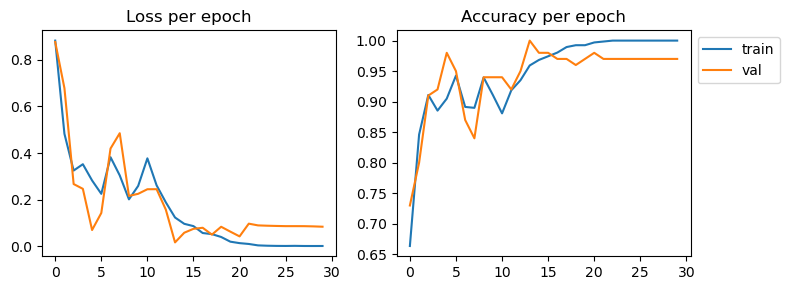

In [98]:
loss_accuracy_per_epoch(history)

### Model 2. Reduce model complexity
Reduce the number of neuron in the ConvLSTM2D layer and the classification layer to reduce the model size

In [19]:
# parameters
model_name = 'mobilenet1_retrain'
num_epochs = 30
batch_size = 8
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 128, 128, False # False for (1,1), True for (3,4)

aug_params = False
# aug_params = {
#     'rotation_range':10, 'brightness_range':[0.4,1.0], 'zoom_range':0.1,
#     'zca_whitening':True, 'width_shift_range':0.1, 'height_shift_range':0.1}

# optimizer
optimizer_adam = optimizers.Adam(learning_rate=1e-3, epsilon=1e-4)
# Reduce LR
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=num_epochs//10, min_lr=1e-5)

# checkpoint
curr_dt_time, training_steps, validation_steps = train_val_steps(train_doc, val_doc, batch_size)
checkpoint = create_checkpoint(model_name, curr_dt_time)
# Callback list
callbacks_list = [LR, checkpoint]
# generator
sequence_length = len(image_indices)
train_generator = generator(train_path, train_doc, batch_size, image_indices, (height, width), use_ratio, aug_params)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)

current_date_time: 2023-10-01_15-28-24 | # training sequences = 663 | # validation sequences = 100
# epochs = 30 | train_steps_per_epoch 83 | val_validation_steps 13


In [20]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(height, width, 3))
mobilenet_transfer.trainable = True

In [21]:
model = Sequential()
model.add(TimeDistributed(
    mobilenet_transfer, input_shape=(sequence_length, height, width, 3))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(16, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 10, 4, 4, 1024)   3228864   
 tributed)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 10, 4, 4, 1024)   4096      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 2, 2, 16)          599104    
                                                                 
 batch_normalization_4 (Batc  (None, 2, 2, 16)         64        
 hNormalization)                                                 
                                                                 
 time_distributed_3 (TimeDis  (None, 2, 2, 64)         1088      
 tributed)                                            

In [22]:
%%time
history = model.fit(train_generator, steps_per_epoch=training_steps, epochs=num_epochs, 
                    validation_data=val_generator, validation_steps=validation_steps, 
                    callbacks=callbacks_list, verbose=1, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.1464 - categorical_accuracy: 0.5490
Epoch 1: val_categorical_accuracy improved from -inf to 0.66000, saving model to model_save/mobilenet1_retrain_2023-10-01_15-28-24\model_001-1.14638-0.54902-1.09279-0.66000.h5
83/83 [==============================] - 25s 242ms/step - loss: 1.1464 - categorical_accuracy: 0.5490 - val_loss: 1.0928 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.6303 - categorical_accuracy: 0.8024
Epoch 2: val_categorical_accuracy improved from 0.66000 to 0.77000, saving model to model_save/mobilenet1_retrain_2023-10-01_15-28-24\model_002-0.63034-0.80241-0.68007-0.77000.h5
83/83 [==============================] - 19s 234ms/step - loss: 0.6303 - categorical_accuracy: 0.8024 - val_loss: 0.6801 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.5685 - categorical_accura

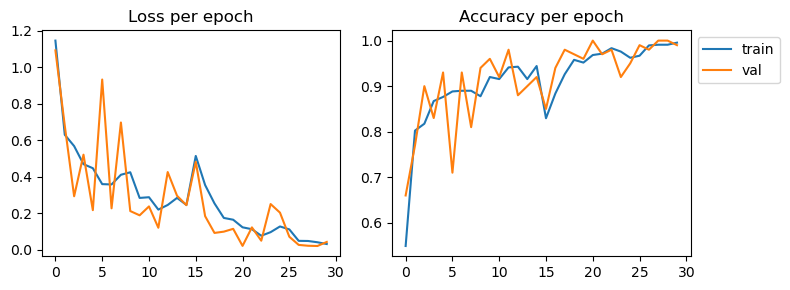

In [23]:
loss_accuracy_per_epoch(history)

### Conclusion from transfer learning

- Initializing the model with mobilenet weights and retraining are necessary. Just training the classification layers and finetuning the CNN layers layers does not help.
- Using pretrained models outperform any handmade model (100% validation accuracy and 0.02 validation loss vs 95% and 0.3 of handmade's).
- While pretrained models size are a lot larger than custom models, mobilenet-based model is still relatively small enough.

# 7. Final model recommendation and test on unseen data

## 7.1 Final model

Considering performance and model size, **Retrained mobilenet + LSTM** is recommended. Reasons:
- Highest validation accuracy (100%).
- Relatively low parameters for such performance.
- Mobilenet was designed to be low-latency, low-power, parameterized to work under the resource constraints.
- Passed all test cases which were unseen during training/validation. (See section 7.3 Test data below)
- From a user experience perspective, TV with gesture recognition tend to be higher end. At such price range, this feature has to be as reliable as possible, or else it will end up just a marketing gimmick that no one actually uses.

Alternative recommendation: **Handmade CNN+LSTM model**. Reason:
- Second highest validation accuracy (95%)
- Extremely small number of parameters (only about 100,000)
- Performance and hardware requirement fitted for mid-low range TV.
- May not work as well on unseen test data.

## Load library

In [1]:
import numpy as np
import os
import cv2
from cv2 import imread
# from scipy.misc import imresize
import datetime
import os
from glob import glob
import matplotlib.pyplot as plt
import time

# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Reshape, Dropout, ConvLSTM2D, GlobalAveragePooling2D, GlobalAveragePooling3D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from keras.models import load_model

In [3]:
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns

### Data path

In [4]:
# local
path = 'project_data/'

# set the seed for the same random permutation each time
np.random.seed(42)
train_doc = np.random.permutation(open(path+'train.csv').readlines())
val_doc = np.random.permutation(open(path+'val.csv').readlines())

train_path = path+'train/'
val_path = path+'val/'

###  Functions for image processing

In [5]:
def minmax_norm(image_channel_array):
    return (image_channel_array - image_channel_array.min()) / (image_channel_array.max() - image_channel_array.min())

In [6]:
# crop image to square size
def center_crop_to_square(img):
    # img expected to be a 3D array (height, width, channel)
    img_height, img_width = img.shape[0], img.shape[1]
    crop_size = int(min(img_height, img_width)/2)
    center_height, center_width = int(img_height/2), int(img_width/2)
    img = img[center_height-crop_size:center_height+crop_size , center_width-crop_size:center_width+crop_size, :]
    return img

In [7]:
# crop image to 4:3 ratio
def center_crop_ratio(img):
    ratio_height, ratio_width = 3, 4
    img_height, img_width = img.shape[0], img.shape[1]
    common_term = int(min(img_height/ratio_height, img_width/ratio_width))
    center_height, center_width = int(img_height/2), int(img_width/2)
    crop_height, crop_width = int(common_term*ratio_height/2), int(common_term*ratio_width/2)
    return img[center_height-crop_height:center_height+crop_height , center_width-crop_width:center_width+crop_width, :]

In [8]:
# resize
def ratio_resize(img, dimension):
    return cv2.resize(img, dimension)

### Generator

In [9]:
def generator(source_path, folder_list, full_batch_size, image_indices, dimension = (64,64), use_ratio=False, augmentation_params = False): 
    seq_length = len(image_indices)
    img_height = dimension[0]
    img_width = dimension[1]
    while True:
        np.random.seed(42)
        t = np.random.permutation(folder_list)
        if augmentation_params!=False:
            datagen = ImageDataGenerator(**augmentation_params)
        # calculate number of batches        
        if len(folder_list) % full_batch_size == 0: # can finish in full batch
            num_batches = len(folder_list) // full_batch_size
            last_batch_size = full_batch_size
        else: # need to specify the remaining batch size
            num_batches = len(folder_list) // full_batch_size + 1
            last_batch_size = len(folder_list) % full_batch_size
        
        # we iterate over the number of batches
        for batch_th in range(num_batches): 
            if batch_th+1 < num_batches: #not yet the last batch
                batch_size = full_batch_size
            else: # last batch reached
                batch_size = last_batch_size
            # (number of sample per batch, x: number of photos in each sample, y: height, z: width, 3 channels)
            batch_data = np.zeros((batch_size,seq_length,img_height,img_width,3)) 
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5)) 
            # iterate over each image and replace the value in batch_data
            for folder_th in range(batch_size):
                # read all the images in the folder
                folder_name = t[(batch_th*full_batch_size) + folder_th].split(';')[0]
                # list of images in a folder. (full path because using glob)
                imgs = glob(source_path+folder_name+'/*')
                
                # get random transform for a sequence (declare the data gen here will apply the same transformation to all images in a sequence)
                if augmentation_params!=False:
                    # datagen = ImageDataGenerator(**augmentation_params)
                    random_transform = datagen.get_random_transform((img_height, img_width, 3))

                # image_indices is a list containing the index of the images we want to use.
                for idx,selected_index in enumerate(image_indices):
                    image = imread(imgs[selected_index])
                    # apply random augmentation
                    if augmentation_params!=False:
                        image = datagen.apply_transform(image, random_transform)
                    # resize/crop
                    if use_ratio==False:
                        image = center_crop_to_square(image)
                        image = ratio_resize(image, (img_width,img_height))
                    else: 
                        image = center_crop_ratio(image)
                        image = ratio_resize(image, (img_width,img_height))
                    
                    # add to the batch data
                    for img_channel in (0,1,2):
                        batch_data[folder_th,idx,:,:,img_channel] = minmax_norm(image[:,:,img_channel])
                    
                batch_labels[folder_th, int(t[(batch_th*full_batch_size) + folder_th].strip().split(';')[2])] = 1
            yield batch_data , batch_labels

### For training/validation

In [10]:
# calculate training steps/validation steps
def train_val_steps(train_doc, val_doc, batch_size):
    curr_dt_time = str(datetime.datetime.now()).replace(' ','_').replace(':','-').split('.')[0]
    print(f'current_date_time: {curr_dt_time}', end=' | ')
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences, end=' | ')
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print ('# epochs =', num_epochs, end=' | ')

    if (num_train_sequences%batch_size) == 0:
        training_steps = int(num_train_sequences/batch_size)
    else:
        training_steps = (num_train_sequences//batch_size) + 1
    print(f'train_steps_per_epoch {training_steps}', end=' | ')
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    print(f'val_validation_steps {validation_steps}')
    return curr_dt_time, training_steps, validation_steps

## 7.2 Load pretrained model

In [11]:
model_path = 'model_021-0.12351-0.96833-0.02163-1.00000.h5'
model = load_model(model_path)

# view model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 10, 4, 4, 1024)   3228864   
 tributed)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 10, 4, 4, 1024)   4096      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 2, 2, 16)          599104    
                                                                 
 batch_normalization_4 (Batc  (None, 2, 2, 16)         64        
 hNormalization)                                                 
                                                                 
 time_distributed_3 (TimeDis  (None, 2, 2, 64)         1088      
 tributed)                                            

### Make prediction on validation set

In [12]:
# parameters
num_epochs = 1
batch_size = 16
image_indices = np.arange(2,30,3) # every 3rd frame
height, width, use_ratio = 128, 128, False # False for (1,1), True for (3,4)

# checkpoint
_, _, validation_steps = train_val_steps(train_doc, val_doc, batch_size)

# generator
sequence_length = len(image_indices)
val_generator = generator(val_path, val_doc, batch_size, image_indices, (height, width), use_ratio)

current_date_time: 2023-10-01_15-49-49 | # training sequences = 663 | # validation sequences = 100
# epochs = 1 | train_steps_per_epoch 42 | val_validation_steps 7


In [13]:
y_val = []
yhat_val = []
for step in range(validation_steps):
    data, label = next(val_generator)
    yhat_val.extend(model.predict(data))
    y_val.extend(label)
    
y_val = np.array(y_val).argmax(axis=1)
yhat_val = np.array(yhat_val).argmax(axis=1)

1/1 [==============================] - 0s 388ms/step


### View model performance

In [14]:
f'Validation accuracy: {accuracy_score(y_val, yhat_val):.4f}'

'Validation accuracy: 1.0000'

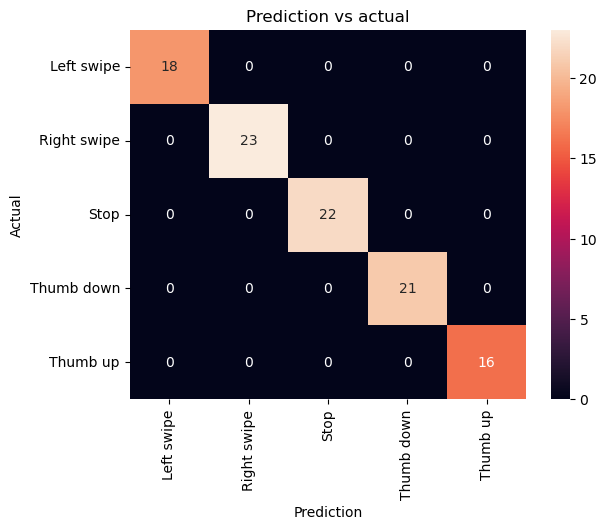

In [15]:
label_names = ['Left swipe', 'Right swipe', 'Stop', 'Thumb down', 'Thumb up']
sns.heatmap(confusion_matrix(y_val, yhat_val), annot=True, xticklabels=label_names, yticklabels=label_names,)
plt.title('Prediction vs actual')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

## 7.3 Test data
- Custom holdout data made by me, include 10 observations (2 cases for each gesture).
- Images were recorded in a relatively poorer lighting than the train/val set: dim light, camera a bit shaky, blurry motion, etc... A particular case was even badly cropped (still have black bars). This was intentional to test the model in harder condition.

**Link to download**: https://drive.google.com/file/d/1jNW4_XZ-c035j74IBoFOcBqbEw2d06h3/view?usp=sharing. 

Extract 'test' folder and 'test.csv' to folder 'project_data/'. Or modify the path below.

In [16]:
path = 'project_data/'
test_doc = np.random.permutation(open(path+'test.csv').readlines())
test_path = path+'test/'

model_path = 'model_014-0.12375-0.95928-0.01712-1.00000.h5' # pretrained model
model = load_model(model_path)

### Make prediction

In [17]:
# parameters
num_epochs = 1
batch_size = 10
image_indices = np.arange(2,30,3) # every 3rd frame

height, width, use_ratio = 128, 128, False #  for pretrained model
# height, width, use_ratio = 72, 96, True # For custom model

# generator
sequence_length = len(image_indices)
test_generator = generator(test_path, test_doc, batch_size, image_indices, (height, width), use_ratio)

In [18]:
# make prediction
y_test = []
yhat_test = []

data, label = next(test_generator)
yhat_test.extend(model.predict(data))
y_test.extend(label)
    
y_test = np.array(y_test).argmax(axis=1)
yhat_test = np.array(yhat_test).argmax(axis=1)

1/1 [==============================] - 1s 1s/step


### View performance

In [19]:
f'Test accuracy: {accuracy_score(y_test, yhat_test):.4f}'

'Test accuracy: 1.0000'

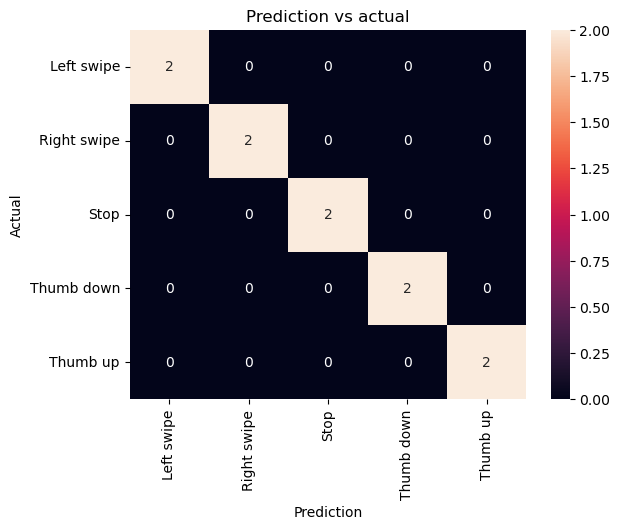

In [20]:
label_names = ['Left swipe', 'Right swipe', 'Stop', 'Thumb down', 'Thumb up']
sns.heatmap(confusion_matrix(y_test, yhat_test), annot=True, xticklabels=label_names, yticklabels=label_names,)
plt.title('Prediction vs actual')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

## 7.5 Making inference

In [21]:
# inference processing
# point to a specific path of a sample

def inference_processing(source_path, image_indices, dimension = (64,64), use_ratio=False): 
    seq_length = len(image_indices)
    img_height = dimension[0]
    img_width = dimension[1]
    
    # (number of sample per batch, x: number of photos in each sample, y: height, z: width, 3 channels)
    image_data = np.zeros((1,seq_length,img_height,img_width,3)) 
    
    # get the list of all the images in source path
    imgs = glob(source_path+'/*')
    
    # for each image in the folder
    for idx,selected_index in enumerate(image_indices):
        image = imread(imgs[selected_index])
        
        # resize/crop
        if use_ratio==False:
            image = center_crop_to_square(image)
            image = ratio_resize(image, (img_width,img_height))
        else: 
            image = center_crop_ratio(image)
            image = ratio_resize(image, (img_width,img_height))

        # add to the batch data
        for img_channel in (0,1,2):
            image_data[0,idx,:,:,img_channel] = minmax_norm(image[:,:,img_channel])

    return image_data

Print the sequence of each case and the probability predicted by the model

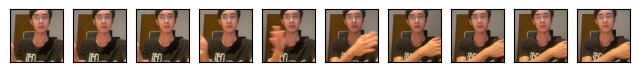

1/1 [==============================] - 0s 299ms/step
Left swipe: 0.9999
Right swipe: 0.0000
Stop: 0.0000
Thumb down: 0.0000
Thumb up: 0.0000


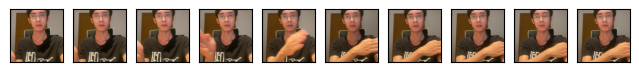

1/1 [==============================] - 0s 44ms/step
Left swipe: 0.9988
Right swipe: 0.0002
Stop: 0.0006
Thumb down: 0.0001
Thumb up: 0.0002


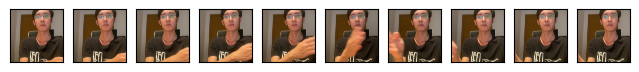

1/1 [==============================] - 0s 46ms/step
Left swipe: 0.0009
Right swipe: 0.9976
Stop: 0.0007
Thumb down: 0.0007
Thumb up: 0.0001


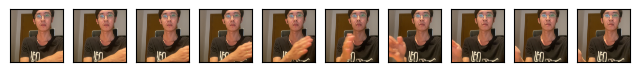

1/1 [==============================] - 0s 45ms/step
Left swipe: 0.0003
Right swipe: 0.9992
Stop: 0.0002
Thumb down: 0.0003
Thumb up: 0.0001


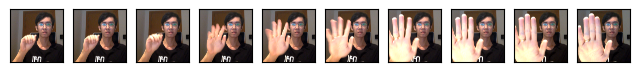

1/1 [==============================] - 0s 47ms/step
Left swipe: 0.0005
Right swipe: 0.0021
Stop: 0.9969
Thumb down: 0.0002
Thumb up: 0.0003


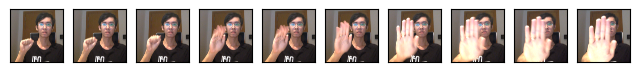

1/1 [==============================] - 0s 51ms/step
Left swipe: 0.0003
Right swipe: 0.0004
Stop: 0.9990
Thumb down: 0.0003
Thumb up: 0.0001


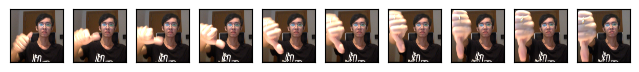

1/1 [==============================] - 0s 45ms/step
Left swipe: 0.0004
Right swipe: 0.0002
Stop: 0.0002
Thumb down: 0.9989
Thumb up: 0.0003


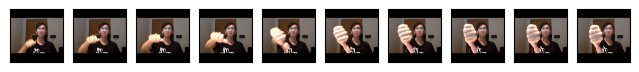

1/1 [==============================] - 0s 47ms/step
Left swipe: 0.0010
Right swipe: 0.0000
Stop: 0.0002
Thumb down: 0.9986
Thumb up: 0.0001


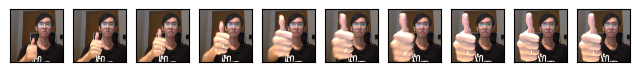

1/1 [==============================] - 0s 46ms/step
Left swipe: 0.0011
Right swipe: 0.0000
Stop: 0.0002
Thumb down: 0.0001
Thumb up: 0.9986


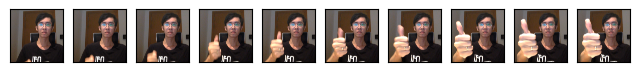

1/1 [==============================] - 0s 47ms/step
Left swipe: 0.0019
Right swipe: 0.0001
Stop: 0.0002
Thumb down: 0.0003
Thumb up: 0.9975


In [22]:
image_indices = np.arange(2,30,3) # every 3rd frame
test_cases = glob(test_path+'/*')

for test_case_path in test_cases:
    #print image sequence
    fig = plt.figure(figsize=(8,2))
    imgs = glob(test_case_path+'/*')
    for i, indx in enumerate(image_indices):
        ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[]) 
        plt.imshow(cv2.cvtColor(imread(imgs[indx]), cv2.COLOR_BGR2RGB))
    plt.show()

    # make inference
    test_case = inference_processing(test_case_path, image_indices, (height, width), use_ratio)
    prediction_proba = model.predict(test_case)
    for label, proba in zip(label_names, prediction_proba[0]):
        print(f'{label}: {proba:.4f}')


***
End of project. Thank you.